In [1]:
import numpy as np
import pandas as pd
import re
import torch
from torchtext import data
import torch.nn as nn
import torch.nn.functional as F

In [2]:
fmf = set.intersection(set(findex[fdiff<0.5]),set(findex[mdiff<0.5]))
r2r3f = set.intersection(set(findex[abs(r2pref-flabel)<0.5]),set(findex[abs(r3pref-flabel)<0.5]))
r2r4f = set.intersection(set(findex[abs(r2pref-flabel)<0.5]),set(findex[abs(r4pref-flabel)<0.5]))
r4r3f = set.intersection(set(findex[abs(r4pref-flabel)<0.5]),set(findex[abs(r3pref-flabel)<0.5]))


fmm = set.intersection(set(mindex[fdifm<0.5]),set(mindex[mdifm<0.5]))
r2r3m = set.intersection(set(mindex[abs(r2prem-mlabel)<0.5]),set(mindex[abs(r3prem-mlabel)<0.5]))
r2r4m = set.intersection(set(mindex[abs(r2prem-mlabel)<0.5]),set(mindex[abs(r4prem-mlabel)<0.5]))
r4r3m = set.intersection(set(mindex[abs(r4prem-mlabel)<0.5]),set(mindex[abs(r3prem-mlabel)<0.5]))


In [250]:
len(findex[mdiff<0.5])

30540

In [251]:
len(findex[abs(r2pref-flabel)<0.5])

30561

In [252]:
len(findex[abs(r3pref-flabel)<0.5])

30816

In [253]:
len(findex[abs(r4pref-flabel)<0.5])

30856

In [8]:
len(set.intersection(set(findex[fdiff<0.5]),set(findex[mdiff>0.5]))) #female data ,f right, m wrong

5253

In [9]:
len(set.intersection(set(findex[fdiff>0.5]),set(findex[mdiff<0.5]))) #female data, f wrong, m right

5093

In [10]:
len(set.intersection(set(mindex[fdifm>0.5]),set(mindex[mdifm<0.5]))) # male data, f wrong ,m right

5866

In [11]:
len(set.intersection(set(mindex[fdifm<0.5]),set(mindex[mdifm>0.5]))) # male data, f right, m wrong

5611

In [155]:
abs(fprefint - mprefint).sum()/len(ftest)

0.2775797579757976

In [156]:
abs(r2prefint - r3prefint).sum()/len(ftest)

0.22803080308030804

In [157]:
abs(r3prefint - r4prefint).sum()/len(ftest)

0.2117051705170517

In [158]:
abs(r2prefint - r4prefint).sum()/len(ftest)

0.22904290429042903

In [163]:
len(ftest)

45450

In [159]:
abs(fpremint - mpremint).sum()/len(mtest)

0.32146773698293635

In [160]:
abs(r2premint - r3premint).sum()/len(mtest)

0.2648374786156073

In [161]:
abs(r3premint-r4premint).sum()/len(mtest)

0.24242224854147476

In [162]:
abs(r2premint-r4premint).sum()/len(mtest)

0.2609992542878449

## load models

In [2]:
BeautyTEXT = data.Field(tokenize='spacy')
#BeautyLABEL = data.LabelField()
BeautyLABEL = data.LabelField(tensor_type=torch.FloatTensor)

print("loading dataset clean_Beauty300.tsv...")
Beautytrain  = data.TabularDataset.splits(
        path='../counter-sent-generation3/VAE/data/official_Amazon/', 
        train='clean_Beauty300.tsv',
        format='tsv',
        fields=[('Text', BeautyTEXT),('Label', BeautyLABEL)])[0]

BeautyTEXT.build_vocab(Beautytrain, max_size=60000, vectors="glove.6B.100d",min_freq=1)
BeautyLABEL.build_vocab(Beautytrain)

BeautyLABEL.vocab.stoi['1']=1
BeautyLABEL.vocab.stoi['2']=2
BeautyLABEL.vocab.stoi['3']=3
BeautyLABEL.vocab.stoi['4']=4
BeautyLABEL.vocab.stoi['5']=5

loading dataset clean_Beauty300.tsv...


In [3]:
ApparelTEXT = data.Field(tokenize='spacy')
#ApparelLABEL = data.LabelField()
ApparelLABEL = data.LabelField(tensor_type=torch.FloatTensor)

print("loading dataset clean_Apparel300.tsv...")
Appareltrain  = data.TabularDataset.splits(
        path='../counter-sent-generation3/VAE/data/official_Amazon/', 
        train='clean_Apparel300.tsv',
        format='tsv',
        fields=[('Text', ApparelTEXT),('Label', ApparelLABEL)])[0]

ApparelTEXT.build_vocab(Appareltrain, max_size=60000, vectors="glove.6B.100d",min_freq=1)
ApparelLABEL.build_vocab(Appareltrain)

ApparelLABEL.vocab.stoi['1']=1
ApparelLABEL.vocab.stoi['2']=2
ApparelLABEL.vocab.stoi['3']=3
ApparelLABEL.vocab.stoi['4']=4
ApparelLABEL.vocab.stoi['5']=5

loading dataset clean_Apparel300.tsv...


In [4]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x):
        
        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        #print("embedded shape: ", embedded.shape)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        #print("output.shape: ",output.shape)
        #print("output[-1].shape: ",output[-1].shape)
        #print("hidden.shape: ",hidden.shape)
        #print("cell.shape: ",cell.shape)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid. dim]
        #cell = [num layers * num directions, batch size, hid. dim]
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        #print("hidden.shape: ",hidden.shape)
        
        y = self.fc(hidden.squeeze(0))
                
        #hidden [batch size, hid. dim * num directions]
            
        #return self.fc(hidden.squeeze(0))
        return y

'''
INPUT_DIM = len(BeautyTEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 500
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
'''
#mrnn3 = torch.load('mrnn3')
#mrnn4 = torch.load('mrnn4', map_location=lambda storage, loc: storage) #force to load on CPU
#frnn4 = torch.load('frnn4', map_location=lambda storage, loc: storage) #force to load on CPU

criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#mrnn4 = mrnn4.to(device)
criterion = criterion.to(device)

In [5]:
#TEXT = BeautyTEXT
#LABEL = BeautyLABEL
Beautymodel = torch.load('Amazon/Beauty_classifier', map_location=lambda storage, loc: storage) #force to load on CPU
Apparelmodel = torch.load('Amazon/Apparel_classifier', map_location=lambda storage, loc: storage) #force to load on CPU
#frnn = torch.load('frnn8')
#mrnn = torch.load('mrnn8')

criterion = nn.MSELoss()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
Beautymodel = Beautymodel.to(device)
Apparelmodel = Apparelmodel.to(device)
criterion = criterion.to(device)

/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [6]:
import spacy
nlp = spacy.load('en')
def predict_sentiment(sentence,model,TEXT):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    model.eval()
    prediction = model(tensor)
    return prediction.item()


def predict_word(word):
    print('Amodel: ',predict_sentiment(word,Beautymodel,BeautyTEXT))
    print('Bmodel:  ',predict_sentiment(word,Apparelmodel,ApparelTEXT))

## find pre_dif of sentences

In [57]:
with open('../counter-sent-generation3/VAE/data/official_Amazon/clean_Beauty300test.tsv') as f:
    Beauty = f.readlines()
with open('../counter-sent-generation3/VAE/data/official_Amazon/clean_Apparel300test.tsv') as f:
    Apparel = f.readlines()
with open('../counter-sent-generation3/VAE/data/official_Amazon/clean_Jewelry300test.tsv') as f:
    Jewelry = f.readlines()
with open('../counter-sent-generation3/VAE/data/official_Amazon/clean_Shoes300test.tsv') as f:
    Shoes = f.readlines()

In [58]:
for i,x in enumerate(Beauty):
    Beauty[i] = x.split('\t')[0]
for i,x in enumerate(Apparel):
    Apparel[i] = x.split('\t')[0]

In [59]:
with open('Amazon/Beauty_pre_Beautytest.txt','r') as f:
    Beauty_pre_Beautyf = f.readlines()
with open('Amazon/Apparel_pre_Beautytest.txt','r') as f:
    Apparel_pre_Beautyf = f.readlines()

with open('Amazon/Beauty_pre_Appareltest.txt','r') as f:
    Beauty_pre_Apparelf = f.readlines()
with open('Amazon/Apparel_pre_Appareltest.txt','r') as f:
    Apparel_pre_Apparelf = f.readlines()

In [60]:
label=[]
Apparellabel=[]
Beauty_pre_Beauty=[]
Apparel_pre_Beauty=[]
Beauty_pre_Apparel=[]
Apparel_pre_Apparel=[]
for x in Beauty_pre_Beautyf:
    label.append(float(x.split('\t')[1].strip('\n')))
    Beauty_pre_Beauty.append(float(x.split('\t')[0]))
for x in Apparel_pre_Beautyf:
    Apparel_pre_Beauty.append(float(x.split('\t')[0]))
for x in Beauty_pre_Apparelf:
    Apparellabel.append(float(x.split('\t')[1].strip('\n')))
    Beauty_pre_Apparel.append(float(x.split('\t')[0]))
for x in Apparel_pre_Apparelf:
    Apparel_pre_Apparel.append(float(x.split('\t')[0]))

In [66]:
label = np.array(label)
Beauty_pre_Beauty = np.array(Beauty_pre_Beauty)
Apparel_pre_Beauty = np.array(Apparel_pre_Beauty)
Apparellabel=np.array(Apparellabel)
Beauty_pre_Apparel=np.array(Beauty_pre_Apparel)
Apparel_pre_Apparel = np.array(Apparel_pre_Apparel)

In [31]:
np.mean((Beauty_pre_Beauty-label)<0.5)

0.8666086494065318

In [32]:
np.mean((Apparel_pre_Beauty-label)<0.5)

0.8353276766504701

In [33]:
np.mean((Jewelry_pre_Beauty-label)<0.5)

0.813281117799212

In [35]:
np.mean((Shoes_pre_Beauty-label)<0.5)

0.8395822757270288

In [62]:
np.mean((Beauty_pre_Apparel-Apparellabel)<0.5)

0.8053365140370641

In [64]:
np.mean((Apparel_pre_Apparel-Apparellabel)<0.5)

0.8281536456607691

In [65]:
Appareldf = pd.DataFrame({'label':Apparellabel,'Beauty_pre':Beauty_pre_Apparel,'Apparel_pre':Apparel_pre_Apparel,"sent":Apparel})

Beautydf = pd.DataFrame({'label':label,'Beauty_pre':Beauty_pre_Beauty,'Apparel_pre':Apparel_pre_Beauty,"Jewelry_pre":Jewelry_pre_Beauty,"Shoes_pre":Shoes_pre_Beauty,"sent":Beauty})

Beautydf['BAdif'] = Beauty_pre_Beauty-Apparel_pre_Beauty
Appareldf['BAdif'] = Beauty_pre_Apparel-Apparel_pre_Apparel

In [69]:
sortedBA = Beautydf.sort_values(by='BAdif',ascending=True)
sortedBA2 = Appareldf.sort_values(by='BAdif',ascending=True)
sortedBA.head()

,label,Beauty_pre,Apparel_pre,Jewelry_pre,Shoes_pre,sent,BAdif
10281,4.0,-5.260822,3.855325,4.045907,3.143246,a little pricy .,-9.116147
31680,5.0,-4.417961,4.647887,2.855498,3.937781,items were satisfactory .,-9.065848
24846,5.0,-4.545552,4.492868,5.106307,4.255400,nothing to complain about here,-9.038420
26510,3.0,-4.201735,4.356722,2.802930,3.968076,so far .,-8.558458
18489,5.0,-4.237140,4.248273,4.721891,0.648613,nice little box .,-8.485414


In [56]:
with open('Beauty_Apparel_predif_on_Beauty300test.txt','w') as f:
    for i in range(len(label)):
        f.write(str(sortedBA.iloc[i]['label'])+'\t'
                +str(sortedBA.iloc[i]['Beauty_pre'])+'\t'
                +str(sortedBA.iloc[i]['Apparel_pre'])+'\t'
                +str(sortedBA.iloc[i]['BAdif'])+'\t'+sortedBA.iloc[i]['sent']+'\n')

In [72]:
with open('Beauty_Apparel_predif_on_Apparel300test.txt','w') as f:
    for i in range(len(Apparellabel)):
        f.write(str(sortedBA2.iloc[i]['label'])+'\t'
                +str(sortedBA2.iloc[i]['Beauty_pre'])+'\t'
                +str(sortedBA2.iloc[i]['Apparel_pre'])+'\t'
                +str(sortedBA2.iloc[i]['BAdif'])+'\t'+sortedBA2.iloc[i]['sent']+'\n')

In [125]:
sortedBA2.head()

,label,Beauty_pre,Apparel_pre,sent,BAdif
7088,1.0,-4.913253,4.120996,cheap hat for high price .,-9.034249
17466,4.0,-5.858836,3.170366,a bit too thick .,-9.029202
11979,1.0,-4.278254,4.729827,dosnt work .,-9.008081
31700,1.0,-6.148802,2.720927,top runs small .,-8.869729
5934,5.0,-4.525872,4.300081,it was a gud gift ! ! !,-8.825953


In [3]:
with open('Amazon/Beauty_Apparel_predif_on_Beauty300test.txt','r') as f:
    B = f.readlines()

In [6]:
B = B[2:]

In [9]:
B[0].split('\t')[3]

'-9.1161470413208'

In [10]:
predif=[]
for x in B:
    predif.append(float(x.split('\t')[3]))

In [13]:
np.mean(np.abs(predif))

0.7909427438510621

## see vocab pre_dif for test data

In [115]:
common = set.intersection(set(BeautyTEXTtest.vocab.itos),set(BeautyTEXT.vocab.itos),set(ApparelTEXT.vocab.itos))

common = list(common)

score=[]
B=[]
A=[]
for key in common:
    Bpre = predict_sentiment(key,Beautymodel,BeautyTEXT)
    Apre = predict_sentiment(key,Apparelmodel,ApparelTEXT)
    B.append(Bpre)
    A.append(Apre)
    score.append(Bpre-Apre)

common_vocab=pd.DataFrame({'vocab':np.array(common),'Beautypre':np.array(B),'Apparelpre':np.array(A),'BAdif':np.array(score)})

sorted2 = common_vocab.sort_values(by='BAdif')
sorted2.head(10)

with open('Amazon/Apparel300test_Beauty300_Apparel300_commonvocab_BeautyApparel_predif','w') as f:
    for i in range(len(score)):
        f.write(sorted2.iloc[i]['vocab']+'\t'
                +str(sorted2.iloc[i]['Beautypre'])+'\t'
                +str(sorted2.iloc[i]['Apparelpre'])+'\t'
                +str(sorted2.iloc[i]['BAdif'])+'\n')

In [8]:
def find_sen(word,test):
    sen=[]
    for i,x in enumerate(test):
        if word in x:
            sen.append(i)
    return sen

def test_otherf(word,n):
    print("fpref: ",fpref[n],' mpref: ',mpref[n])
    scorem = predict_sentiment(re.sub(word,'',ftest[n]),mrnn,BeautyTEXT)
    scoref = predict_sentiment(re.sub(word,'',ftest[n]),frnn,ApparelTEXT)
    print("scoref: ",scoref," scorem: ",scorem)
    
def test_otherm(word,n):
    print("fprem: ",fprem[n],' mprem: ',mprem[n])
    scorem = predict_sentiment(re.sub(word,'',mtest[n]),mrnn,BeautyTEXT)
    scoref = predict_sentiment(re.sub(word,'',mtest[n]),frnn,ApparelTEXT)
    print("scoref: ",scoref," scorem: ",scorem)

In [254]:
ls200=[]
for i,x in enumerate(mtest):
    if len(x)<200:
        ls200.append(i)

In [255]:
len(ls200)

12008

In [3]:
fdf.sort_values(by='f-m',ascending=False).head(20)

,flabel,fpref,mpref,f-m,fdiff,mdiff
45429,1,4.827479,0.748565,4.078914,3.827479,0.251435
25892,3,0.890751,4.882154,3.991404,2.109249,1.882154
44120,1,4.818519,0.987276,3.831243,3.818519,0.012724
44776,1,4.736845,0.909827,3.827018,3.736845,0.090173
26747,1,4.873995,1.047208,3.826787,3.873995,0.047208
11161,4,1.014760,4.839989,3.825229,2.985240,0.839989
6870,5,4.907516,1.119730,3.787786,0.092484,3.880270
14754,5,4.889979,1.116790,3.773189,0.110021,3.883210
24186,4,5.703376,1.933893,3.769483,1.703376,2.066107
24187,4,5.703376,1.933893,3.769483,1.703376,2.066107


"awesome studio , amazing instructors , awful management from the owner . he goes through instructors and directors like nobody 's business , and if there 's a conflict or misunderstanding , he 's always right and you are always wrong . stay away from dr. lynch and you will do fine . everyone else there is amazing . just do n't get too attached to your favorite instructor - who knows how long he or she will be there .\t3\n"

In [266]:
ftest[6870]

'raw rude shockingly incredible !! extreme talent and hilarious . we smiled from the minute we walked in to crying laughing !\t5\n'

In [258]:
#fdf.iloc[ls200].sort_values(by='f-m',ascending=False).head(20)

In [100]:
mdf.iloc[5001]

mlabel    1.000000
fprem     4.636949
mprem     1.026786
f-m       3.610162
fdifm     3.636949
mdifm     0.026786
Name: 5001, dtype: float64

In [76]:
ftest[13344]

'good pizza\t3\n'

In [77]:
predict_word('pizza')

frnn:  3.586021900177002
mrnn:   2.816215753555298


In [150]:
ls = mdf.sort_values(by='f-m',ascending=False).index

In [151]:
mdf.sort_values(by='f-m',ascending=False).head(20)

,mlabel,fprem,mprem,f-m,fdifm,mdifm
31286,5,4.576482,0.497979,4.078504,0.423518,4.502021
11674,1,0.977704,5.008894,4.031190,0.022296,4.008894
32421,1,4.964299,0.962890,4.001409,3.964299,0.037110
40648,4,4.820684,0.860072,3.960612,0.820684,3.139928
25256,5,0.946319,4.819388,3.873070,4.053681,0.180612
35806,1,0.997295,4.840105,3.842811,0.002705,3.840105
34212,4,1.041868,4.853152,3.811285,2.958132,0.853152
39416,3,4.663486,0.856632,3.806854,1.663486,2.143368
20757,5,4.962842,1.157956,3.804886,0.037158,3.842044
16916,1,4.846434,1.086957,3.759477,3.846434,0.086957


In [158]:
n = ls[5] #14
print(n)
mtest[n]

35806


"10 bucks for a horrible buffet in a grimy strip mall . the irony is that the owner -lrb- according to articles on the wall -rrb- is responsible for renu korn in norwalk , ca , the best thai place i 've ever been to ...\t1\n"

In [177]:
n = ls[15]
print(n)
mtest[n]

17796


'these donuts are absolutely ridiculous ! individually handmade to order , perfect presentation , fresh and hot . i never thought such artistic excellence could be applied to a mere donut . i drive 30 minutes each way for these beautiful babies !\t5\n'

In [130]:
#import re
#re.split('[^a-zA-Z\sn\'t]',s)

In [267]:
n = 6870
s = ftest[n].split('\t')[0]
exam=[]
tokens = s.split()
print("index: ",n, " fpref: ",fpref[n]," mpref: ",mpref[n])
for i in range(len(tokens)):
    scorem = predict_sentiment(re.sub(tokens[i],'',s,count=1),mrnn,BeautyTEXT)
    scoref = predict_sentiment(re.sub(tokens[i],'',s,count=1),frnn,ApparelTEXT)
    print(i,"scoref: ",scoref," scorem: ",scorem)
    if abs(scoref-fpref[n])>1.5 or abs(scorem-mpref[n])>1.5:
        exam.append([i,tokens[i],(fpref[n],scoref),(mpref[n],scorem)])

index:  6870  fpref:  4.907515525817871  mpref:  1.11972975730896
0 scoref:  4.923969268798828  scorem:  4.441247940063477
1 scoref:  4.835933208465576  scorem:  4.762550354003906
2 scoref:  4.805592060089111  scorem:  1.15167236328125
3 scoref:  3.508375644683838  scorem:  1.061444878578186
4 scoref:  4.784595489501953  scorem:  1.101364254951477
5 scoref:  4.898013114929199  scorem:  1.3200550079345703
6 scoref:  4.909206390380859  scorem:  1.0445395708084106
7 scoref:  4.89656925201416  scorem:  1.0363208055496216
8 scoref:  4.710054874420166  scorem:  1.0838749408721924
9 scoref:  4.905917167663574  scorem:  4.30250358581543
10 scoref:  4.889615535736084  scorem:  1.1327636241912842
11 scoref:  4.899408340454102  scorem:  1.1536160707473755
12 scoref:  4.899385452270508  scorem:  1.138744831085205
13 scoref:  4.904638290405273  scorem:  1.1198145151138306
14 scoref:  4.8992156982421875  scorem:  1.1062310934066772
15 scoref:  4.889615535736084  scorem:  1.1327636241912842
16 scoref

In [268]:
exam

[[0,
  'raw',
  (4.907515525817871, 4.923969268798828),
  (1.11972975730896, 4.441247940063477)],
 [1,
  'rude',
  (4.907515525817871, 4.835933208465576),
  (1.11972975730896, 4.762550354003906)],
 [9,
  '.',
  (4.907515525817871, 4.905917167663574),
  (1.11972975730896, 4.30250358581543)]]

In [178]:
s = mtest[n].split('\t')[0]
exam=[]
tokens = s.split()
print("index: ",n, " fprem: ",fprem[n]," mprem: ",mprem[n])
for i in range(len(tokens)):
    scorem = predict_sentiment(re.sub(tokens[i],'',s,count=1),mrnn,BeautyTEXT)
    scoref = predict_sentiment(re.sub(tokens[i],'',s,count=1),frnn,ApparelTEXT)
    print(i,"scoref: ",scoref," scorem: ",scorem)
    if abs(scoref-fprem[n])>1.5 or abs(scorem-mprem[n])>1.5:
        exam.append([i,tokens[i],(fprem[n],scoref),(mprem[n],scorem)])

index:  17796  fprem:  4.932023048400879  mprem:  1.2126375436782837
0 scoref:  4.878260612487793  scorem:  1.1957519054412842
1 scoref:  4.8988728523254395  scorem:  1.18604576587677
2 scoref:  4.893959045410156  scorem:  2.1300063133239746
3 scoref:  4.791556358337402  scorem:  3.0592453479766846
4 scoref:  4.959413528442383  scorem:  4.834939479827881
5 scoref:  4.8443498611450195  scorem:  1.3647243976593018
6 scoref:  4.911673545837402  scorem:  1.1134576797485352
7 scoref:  4.9368743896484375  scorem:  1.1030285358428955
8 scoref:  4.9369378089904785  scorem:  1.2528554201126099
9 scoref:  4.943528175354004  scorem:  1.2536571025848389
10 scoref:  4.877906322479248  scorem:  1.1329269409179688
11 scoref:  4.764839172363281  scorem:  1.0402518510818481
12 scoref:  4.896470069885254  scorem:  1.5100317001342773
13 scoref:  4.877906322479248  scorem:  1.1329269409179688
14 scoref:  4.8723859786987305  scorem:  1.124531626701355
15 scoref:  4.9368743896484375  scorem:  1.103028535842

In [184]:
s = "These donuts are absolutely ridiculous! Individually handmade to order, perfect presentation, fresh and hot. I never thought such artistic excellence could be applied to a mere donut. I drive 30 minutes each way for these beautiful babies! "

In [186]:
s = "These donuts are absolutely ridiculous! Individually handmade to order, perfect presentation, fresh and hot. I never thought such artistic excellence could be applied to a mere donut."

In [187]:
predict_word(s)

frnn:  4.187247276306152
mrnn:   4.787534713745117


In [189]:
predict_word("I drive 30 minutes each way for these beautiful babies!")

frnn:  4.870868682861328
mrnn:   1.0568063259124756


In [179]:
exam  # removing '23rd' lower the female model score, this is also true for other sentences in ftest which contain '23rd'

[[3,
  'absolutely',
  (4.932023048400879, 4.791556358337402),
  (1.2126375436782837, 3.0592453479766846)],
 [4,
  'ridiculous',
  (4.932023048400879, 4.959413528442383),
  (1.2126375436782837, 4.834939479827881)],
 [18,
  'i',
  (4.932023048400879, 4.959413528442383),
  (1.2126375436782837, 4.834939479827881)],
 [32,
  'i',
  (4.932023048400879, 4.959413528442383),
  (1.2126375436782837, 4.834939479827881)],
 [41,
  'babies',
  (4.932023048400879, 4.975104331970215),
  (1.2126375436782837, 4.92854118347168)]]

In [183]:
predict_word('babies')

frnn:  1.8468971252441406
mrnn:   0.1990654468536377


-------------

## back-translation

In [68]:
from googletrans import Translator
import googletrans

translator = Translator()

In [69]:
s

'raw rude shockingly incredible !! extreme talent and hilarious . we smiled from the minute we walked in to crying laughing !'

In [70]:
lang = ['fr','de','es','ru','it','ja','ko','zh-cn']
trans = []

In [73]:
print("original sentence:")
print(s)
predict_word(s)
print('\n')
for l in lang:
    tmp = translator.translate(s,dest=l ).text
    des = translator.translate(tmp,dest='en').text
    print(l,'###',des)
    predict_word(des)
    print('\n')

original sentence:
raw rude shockingly incredible !! extreme talent and hilarious . we smiled from the minute we walked in to crying laughing !
frnn:  4.907515525817871
mrnn:   1.11972975730896


fr ### gross gross incredibly amazing !! extreme and hilarious talent. We smiled the minute we came in crying with laughter!
frnn:  4.771974563598633
mrnn:   3.9099040031433105


de ### raw rude shockingly unbelievable !! extreme talent and hilarious. we smiled from the minute we entered and wept!
frnn:  4.405974864959717
mrnn:   1.241499423980713


es ### Raw rude incredibly amazing! extreme and hilarious talent. We smile from the moment we enter to cry with laughter!
frnn:  4.966532230377197
mrnn:   4.945548057556152


ru ### rough grossly stunningly incredible !! extreme talent and fun. we smiled from the moment when we entered to cry, laughing!
frnn:  4.843025207519531
mrnn:   4.730197429656982


it ### raw rude incredibly amazing !! extreme and exhilarating talent. we smiled from the mome

In [43]:
googletrans.LANGUAGES

{'af': 'afrikaans',
 'sq': 'albanian',
 'am': 'amharic',
 'ar': 'arabic',
 'hy': 'armenian',
 'az': 'azerbaijani',
 'eu': 'basque',
 'be': 'belarusian',
 'bn': 'bengali',
 'bs': 'bosnian',
 'bg': 'bulgarian',
 'ca': 'catalan',
 'ceb': 'cebuano',
 'ny': 'chichewa',
 'zh-cn': 'chinese (simplified)',
 'zh-tw': 'chinese (traditional)',
 'co': 'corsican',
 'hr': 'croatian',
 'cs': 'czech',
 'da': 'danish',
 'nl': 'dutch',
 'en': 'english',
 'eo': 'esperanto',
 'et': 'estonian',
 'tl': 'filipino',
 'fi': 'finnish',
 'fr': 'french',
 'fy': 'frisian',
 'gl': 'galician',
 'ka': 'georgian',
 'de': 'german',
 'el': 'greek',
 'gu': 'gujarati',
 'ht': 'haitian creole',
 'ha': 'hausa',
 'haw': 'hawaiian',
 'iw': 'hebrew',
 'hi': 'hindi',
 'hmn': 'hmong',
 'hu': 'hungarian',
 'is': 'icelandic',
 'ig': 'igbo',
 'id': 'indonesian',
 'ga': 'irish',
 'it': 'italian',
 'ja': 'japanese',
 'jw': 'javanese',
 'kn': 'kannada',
 'kk': 'kazakh',
 'km': 'khmer',
 'ko': 'korean',
 'ku': 'kurdish (kurmanji)',
 'ky

In [119]:
predict_word(re.split('[^a-zA-Z\sn\'t]',s)[0])

frnn:  2.2347726821899414
mrnn:   0.9317804574966431


In [120]:
for i in range(20):
    if flabel[i]==5:
        print(i,ftest[i])

0 this was awesome ! we booked the crawl for two nights , thursday and friday were both great , the free drinks on the bus were awesome -lrb- and surprisingly strong -rrb- . jessica was awesome ! she does her best to make sure you have a great time . we were wearing flats and one of the bouncers were not going to let us in , but jessica somehow talked him into letting us in . i do n't know how she deals with all those people but she 's amazing !	5

5 pilates with julie rock	5

6 the proprietor is so friendly . they have a terrific selection of smoothies and juices and there is no problem finding out what the ingredients are ! prices are very reasonable for fresh juice .	5

7 phoenix is one of only 6 cities to get a center like this . they 've taken a derelict parcel of ground and converted it into something beautiful and sustainable . every time i go i see some special bird or bug that i have n't seen before . the river pathways program is amazing and available to kids who might otherw

In [166]:
predict_word("request")

frnn:  4.922758102416992
mrnn:   0.41144347190856934


In [167]:
ApparelTEXT.vocab.freqs['request']

772

In [168]:
BeautyTEXT.vocab.freqs['request']

640

In [222]:
w='never'
ls = find_sen(w,ftest)

In [223]:
ftest[ls[0]]

"nothing over 9 at noon . this is my go-to lunch spot . i like the salmon a lot but i get it with a salad instead of risotto . the trio which changes daily is a great idea . it 's a salad , soup and sandwich but in proportions that make it doable for lunch . the beet salad is fresh and local and the service is always really good . they call me by my name and that goes a long ways . there 's a terrific private room if you reserve it and this place is never too noisy to carry on a conversation .\t4\n"

In [224]:
for i,n in enumerate(ls):
    print(i,test_other(w,n,ftest))
    print('\n')

fpref:  4.264288902282715  mpref:  4.400808334350586
scoref:  4.124119281768799  scorem:  4.237969398498535
0 None


fpref:  4.957824230194092  mpref:  4.888254165649414
scoref:  4.947081565856934  scorem:  4.908557891845703
1 None


fpref:  4.207095146179199  mpref:  4.1553802490234375
scoref:  4.16385555267334  scorem:  4.285626411437988
2 None


fpref:  0.9712629318237305  mpref:  1.0355024337768555
scoref:  1.0398167371749878  scorem:  1.064441204071045
3 None


fpref:  4.882734298706055  mpref:  4.845616340637207
scoref:  4.890263557434082  scorem:  4.815845489501953
4 None


fpref:  0.9755735993385315  mpref:  1.0272612571716309
scoref:  1.104866623878479  scorem:  1.0353797674179077
5 None


fpref:  4.92609977722168  mpref:  4.933331489562988
scoref:  4.917429447174072  scorem:  4.902327060699463
6 None


fpref:  4.635919570922852  mpref:  4.924106597900391
scoref:  4.7022600173950195  scorem:  4.886049747467041
7 None


fpref:  4.062519073486328  mpref:  3.797032117843628
score

scoref:  4.814563751220703  scorem:  4.828527450561523
69 None


fpref:  4.821136474609375  mpref:  4.870238304138184
scoref:  4.6991472244262695  scorem:  4.869024276733398
70 None


fpref:  4.908754348754883  mpref:  4.672573089599609
scoref:  4.949544906616211  scorem:  4.696264266967773
71 None


fpref:  1.531201720237732  mpref:  1.8264089822769165
scoref:  1.9947346448898315  scorem:  2.1427555084228516
72 None


fpref:  4.857183456420898  mpref:  4.807529449462891
scoref:  4.844770431518555  scorem:  4.660562515258789
73 None


fpref:  0.8275381326675415  mpref:  0.9907582402229309
scoref:  0.9224661588668823  scorem:  1.0459105968475342
74 None


fpref:  3.9591360092163086  mpref:  4.486474990844727
scoref:  4.413364410400391  scorem:  4.749083995819092
75 None


fpref:  4.2512688636779785  mpref:  4.573729038238525
scoref:  4.157780170440674  scorem:  4.606592178344727
76 None


fpref:  1.829275369644165  mpref:  2.5894851684570312
scoref:  1.9833176136016846  scorem:  2.71468

scoref:  4.128391265869141  scorem:  4.583106994628906
138 None


fpref:  4.141319274902344  mpref:  2.975224494934082
scoref:  3.9670441150665283  scorem:  3.0471768379211426
139 None


fpref:  4.807453632354736  mpref:  3.9728195667266846
scoref:  4.805749893188477  scorem:  3.9640309810638428
140 None


fpref:  4.801030158996582  mpref:  4.562068939208984
scoref:  4.8517985343933105  scorem:  4.583883285522461
141 None


fpref:  4.8288140296936035  mpref:  4.788469314575195
scoref:  4.861730575561523  scorem:  4.761848449707031
142 None


fpref:  4.762833595275879  mpref:  5.002655982971191
scoref:  4.80409574508667  scorem:  4.941566467285156
143 None


fpref:  5.009456157684326  mpref:  4.8935089111328125
scoref:  4.961915969848633  scorem:  4.94374942779541
144 None


fpref:  1.2670475244522095  mpref:  1.6927372217178345
scoref:  1.8484448194503784  scorem:  1.9595493078231812
145 None


fpref:  0.9046287536621094  mpref:  1.0249148607254028
scoref:  0.946448564529419  scorem:  

scoref:  4.659671783447266  scorem:  4.643643379211426
207 None


fpref:  3.8272109031677246  mpref:  2.75251841545105
scoref:  3.669827699661255  scorem:  2.9058914184570312
208 None


fpref:  2.570560932159424  mpref:  2.4499828815460205
scoref:  1.9054304361343384  scorem:  2.3714027404785156
209 None


fpref:  2.1696815490722656  mpref:  2.5233144760131836
scoref:  2.027092695236206  scorem:  2.593834161758423
210 None


fpref:  1.2632708549499512  mpref:  1.814882755279541
scoref:  2.0193495750427246  scorem:  2.002472400665283
211 None


fpref:  4.8502912521362305  mpref:  4.704305648803711
scoref:  4.834927558898926  scorem:  4.698444366455078
212 None


fpref:  3.3791675567626953  mpref:  3.907674789428711
scoref:  3.472913980484009  scorem:  4.020103454589844
213 None


fpref:  1.0016539096832275  mpref:  1.0889670848846436
scoref:  1.0341445207595825  scorem:  1.037157654762268
214 None


fpref:  4.956502914428711  mpref:  4.894252777099609
scoref:  4.920843124389648  scorem:

scoref:  0.8832515478134155  scorem:  0.9657407999038696
276 None


fpref:  3.0926408767700195  mpref:  2.109931707382202
scoref:  3.643766403198242  scorem:  3.231794834136963
277 None


fpref:  4.95163631439209  mpref:  4.861885070800781
scoref:  4.916904449462891  scorem:  4.882234573364258
278 None


fpref:  4.845956802368164  mpref:  4.827523231506348
scoref:  4.83669376373291  scorem:  4.841518402099609
279 None


fpref:  1.1573753356933594  mpref:  1.1172066926956177
scoref:  1.278921365737915  scorem:  1.2320990562438965
280 None


fpref:  4.95458984375  mpref:  4.845020771026611
scoref:  4.906908988952637  scorem:  4.886475563049316
281 None


fpref:  4.805619716644287  mpref:  4.767008304595947
scoref:  4.747828483581543  scorem:  4.813302516937256
282 None


fpref:  0.8549484014511108  mpref:  0.943605899810791
scoref:  0.9386019706726074  scorem:  0.9631409645080566
283 None


fpref:  4.868043899536133  mpref:  4.815417289733887
scoref:  4.9437642097473145  scorem:  4.86796

scoref:  4.270934104919434  scorem:  4.344594955444336
346 None


fpref:  0.9271489381790161  mpref:  0.9508068561553955
scoref:  1.0609952211380005  scorem:  1.0802996158599854
347 None


fpref:  4.499275207519531  mpref:  4.797019004821777
scoref:  4.6964545249938965  scorem:  4.802768707275391
348 None


fpref:  1.081767201423645  mpref:  1.0557889938354492
scoref:  1.0447543859481812  scorem:  1.0412920713424683
349 None


fpref:  2.8440136909484863  mpref:  3.629260778427124
scoref:  2.821483612060547  scorem:  3.69563889503479
350 None


fpref:  4.8033905029296875  mpref:  4.668566703796387
scoref:  4.908824920654297  scorem:  4.714285850524902
351 None


fpref:  0.8700162768363953  mpref:  0.9530509114265442
scoref:  0.9089876413345337  scorem:  1.0013715028762817
352 None


fpref:  0.832639217376709  mpref:  0.965675950050354
scoref:  0.8987805843353271  scorem:  0.9499717950820923
353 None


fpref:  0.9604301452636719  mpref:  1.24126398563385
scoref:  0.9926362037658691  scor

scoref:  4.887999534606934  scorem:  4.892365455627441
415 None


fpref:  4.75692081451416  mpref:  4.852603435516357
scoref:  4.690468788146973  scorem:  4.770849227905273
416 None


fpref:  4.872987747192383  mpref:  4.823770523071289
scoref:  4.853720664978027  scorem:  4.812542915344238
417 None


fpref:  0.8831197023391724  mpref:  0.9994412660598755
scoref:  0.9250871539115906  scorem:  1.0269721746444702
418 None


fpref:  2.614729404449463  mpref:  2.9472317695617676
scoref:  2.330594539642334  scorem:  2.9683432579040527
419 None


fpref:  4.704977989196777  mpref:  4.82118034362793
scoref:  4.707623481750488  scorem:  4.702489852905273
420 None


fpref:  4.687719821929932  mpref:  3.9798583984375
scoref:  4.505311965942383  scorem:  3.717434883117676
421 None


fpref:  1.0511209964752197  mpref:  0.8888742327690125
scoref:  1.2705204486846924  scorem:  0.9877796769142151
422 None


fpref:  4.730982303619385  mpref:  4.778615951538086
scoref:  4.733837127685547  scorem:  4.815

scoref:  3.4625532627105713  scorem:  3.1854848861694336
485 None


fpref:  3.9238462448120117  mpref:  3.857111692428589
scoref:  3.9423468112945557  scorem:  3.920576810836792
486 None


fpref:  4.797109127044678  mpref:  4.887317657470703
scoref:  4.712253570556641  scorem:  4.905857563018799
487 None


fpref:  1.9611252546310425  mpref:  1.750841498374939
scoref:  2.074460029602051  scorem:  1.899359107017517
488 None


fpref:  1.0179638862609863  mpref:  0.9653704762458801
scoref:  0.9997434020042419  scorem:  0.9661540985107422
489 None


fpref:  0.9630462527275085  mpref:  1.0033353567123413
scoref:  0.9817989468574524  scorem:  1.0543115139007568
490 None


fpref:  0.910942792892456  mpref:  0.993729829788208
scoref:  0.9599947929382324  scorem:  1.0509604215621948
491 None


fpref:  4.634333610534668  mpref:  4.770120620727539
scoref:  4.6631364822387695  scorem:  4.736074447631836
492 None


fpref:  4.173598766326904  mpref:  4.8760552406311035
scoref:  4.0442304611206055  sc

scoref:  2.6268746852874756  scorem:  2.358661651611328
554 None


fpref:  4.894082069396973  mpref:  4.852269649505615
scoref:  4.969552993774414  scorem:  4.893148422241211
555 None


fpref:  1.7649412155151367  mpref:  1.7278238534927368
scoref:  1.687051773071289  scorem:  1.8885600566864014
556 None


fpref:  3.951880931854248  mpref:  4.007174015045166
scoref:  3.8786144256591797  scorem:  3.981095790863037
557 None


fpref:  4.816309928894043  mpref:  4.950283050537109
scoref:  4.83653450012207  scorem:  4.913601875305176
558 None


fpref:  4.841958999633789  mpref:  4.624228477478027
scoref:  4.979233741760254  scorem:  4.52989387512207
559 None


fpref:  4.865660667419434  mpref:  4.846693992614746
scoref:  4.855181694030762  scorem:  4.830751419067383
560 None


fpref:  4.948460578918457  mpref:  4.9254655838012695
scoref:  5.009565353393555  scorem:  4.910101413726807
561 None


fpref:  4.807744026184082  mpref:  4.874655723571777
scoref:  4.854562759399414  scorem:  4.89521

scoref:  3.190730094909668  scorem:  3.6034367084503174
623 None


fpref:  4.895998954772949  mpref:  4.8722124099731445
scoref:  4.891571044921875  scorem:  4.869476318359375
624 None


fpref:  4.905552387237549  mpref:  3.919105291366577
scoref:  5.003140926361084  scorem:  4.028302192687988
625 None


fpref:  4.8015899658203125  mpref:  4.721896171569824
scoref:  4.930654525756836  scorem:  4.678826332092285
626 None


fpref:  4.840081691741943  mpref:  4.892946243286133
scoref:  4.903369903564453  scorem:  4.801596641540527
627 None


fpref:  4.843217849731445  mpref:  4.829438209533691
scoref:  4.922677993774414  scorem:  4.887366771697998
628 None


fpref:  3.9480669498443604  mpref:  4.111218452453613
scoref:  4.080469131469727  scorem:  4.213502883911133
629 None


fpref:  4.783449172973633  mpref:  4.911623954772949
scoref:  4.811383247375488  scorem:  4.912405490875244
630 None


fpref:  1.415899634361267  mpref:  1.0416851043701172
scoref:  1.6977263689041138  scorem:  1.087

scoref:  4.133092880249023  scorem:  4.230616569519043
691 None


fpref:  4.838033676147461  mpref:  4.896880149841309
scoref:  4.951053619384766  scorem:  4.933296203613281
692 None


fpref:  4.8758745193481445  mpref:  4.908595085144043
scoref:  4.872611045837402  scorem:  4.8748779296875
693 None


fpref:  4.948277950286865  mpref:  4.8789873123168945
scoref:  4.870107650756836  scorem:  4.9144439697265625
694 None


fpref:  4.614773750305176  mpref:  4.7901716232299805
scoref:  4.751589775085449  scorem:  4.833073616027832
695 None


fpref:  0.9899996519088745  mpref:  1.5181875228881836
scoref:  0.9843432903289795  scorem:  1.5841807126998901
696 None


fpref:  4.714537143707275  mpref:  4.751092433929443
scoref:  4.308529853820801  scorem:  4.339686393737793
697 None


fpref:  4.852948188781738  mpref:  4.716213703155518
scoref:  4.910871982574463  scorem:  4.749810218811035
698 None


fpref:  4.941911697387695  mpref:  4.876062393188477
scoref:  4.898813724517822  scorem:  4.896

scoref:  3.890001058578491  scorem:  3.8428354263305664
760 None


fpref:  3.824207067489624  mpref:  4.084376811981201
scoref:  3.5454118251800537  scorem:  4.060878753662109
761 None


fpref:  1.9848484992980957  mpref:  1.6661075353622437
scoref:  2.3960742950439453  scorem:  1.7759512662887573
762 None


fpref:  4.4039201736450195  mpref:  4.297145843505859
scoref:  4.226810455322266  scorem:  4.325368881225586
763 None


fpref:  4.417858123779297  mpref:  4.731316566467285
scoref:  4.1483259201049805  scorem:  4.305680751800537
764 None


fpref:  4.842077255249023  mpref:  4.740512847900391
scoref:  4.911568641662598  scorem:  4.835092544555664
765 None


fpref:  4.311846733093262  mpref:  4.838683128356934
scoref:  4.369296073913574  scorem:  4.8874592781066895
766 None


fpref:  1.632497787475586  mpref:  1.9315030574798584
scoref:  2.0480055809020996  scorem:  2.090991497039795
767 None


fpref:  4.76190185546875  mpref:  4.842442512512207
scoref:  4.795701026916504  scorem:  4

scoref:  1.0078299045562744  scorem:  1.036035418510437
829 None


fpref:  4.200238227844238  mpref:  4.240592002868652
scoref:  4.328005790710449  scorem:  4.396727561950684
830 None


fpref:  4.936086654663086  mpref:  4.894510269165039
scoref:  4.901373863220215  scorem:  4.90664529800415
831 None


fpref:  4.879552841186523  mpref:  4.847626686096191
scoref:  4.902242660522461  scorem:  4.871410369873047
832 None


fpref:  4.991667747497559  mpref:  4.955399513244629
scoref:  4.943562984466553  scorem:  4.937108039855957
833 None


fpref:  4.579426288604736  mpref:  1.0147066116333008
scoref:  4.551198959350586  scorem:  1.0967788696289062
834 None


fpref:  2.7528953552246094  mpref:  3.253387212753296
scoref:  2.7097301483154297  scorem:  3.336676836013794
835 None


fpref:  4.106905460357666  mpref:  4.221417427062988
scoref:  4.661340713500977  scorem:  4.385632514953613
836 None


fpref:  3.8403165340423584  mpref:  3.7390174865722656
scoref:  3.9504854679107666  scorem:  3.85

scoref:  4.800204277038574  scorem:  4.400317192077637
898 None


fpref:  0.9687057733535767  mpref:  0.9695641398429871
scoref:  2.28997802734375  scorem:  1.9822269678115845
899 None


fpref:  4.788339138031006  mpref:  3.8263721466064453
scoref:  4.8306965827941895  scorem:  3.9176290035247803
900 None


fpref:  3.302095890045166  mpref:  2.880736827850342
scoref:  3.2630276679992676  scorem:  2.0480124950408936
901 None


fpref:  4.007415771484375  mpref:  4.28336763381958
scoref:  3.969332456588745  scorem:  4.158200263977051
902 None


fpref:  0.9506828188896179  mpref:  1.0742127895355225
scoref:  1.008324384689331  scorem:  1.1297829151153564
903 None


fpref:  1.2974387407302856  mpref:  1.029396891593933
scoref:  4.09492301940918  scorem:  3.2176010608673096
904 None


fpref:  1.0813660621643066  mpref:  1.5210752487182617
scoref:  1.9785752296447754  scorem:  1.7850737571716309
905 None


fpref:  4.892041206359863  mpref:  4.913128852844238
scoref:  4.780012607574463  scorem

scoref:  1.5740059614181519  scorem:  1.8544989824295044
967 None


fpref:  4.577732563018799  mpref:  4.867300987243652
scoref:  4.726243019104004  scorem:  4.866761207580566
968 None


fpref:  4.188158988952637  mpref:  4.753286361694336
scoref:  4.079469680786133  scorem:  4.798910140991211
969 None


fpref:  0.8956189751625061  mpref:  1.1693364381790161
scoref:  1.1837326288223267  scorem:  2.2555675506591797
970 None


fpref:  4.85902214050293  mpref:  4.820815086364746
scoref:  4.805267333984375  scorem:  4.893573760986328
971 None


fpref:  4.926408767700195  mpref:  4.907123565673828
scoref:  4.895655632019043  scorem:  4.908656120300293
972 None


fpref:  4.875848770141602  mpref:  4.801303863525391
scoref:  4.831960678100586  scorem:  4.8543701171875
973 None


fpref:  1.087744116783142  mpref:  0.952991247177124
scoref:  1.1177035570144653  scorem:  0.9950128793716431
974 None


fpref:  2.1343111991882324  mpref:  1.0083420276641846
scoref:  2.326765775680542  scorem:  1.15

scoref:  4.795923233032227  scorem:  4.495563507080078
1035 None


fpref:  1.7121350765228271  mpref:  1.519835352897644
scoref:  1.63609778881073  scorem:  1.7193114757537842
1036 None


fpref:  1.546878457069397  mpref:  1.3750052452087402
scoref:  1.8022581338882446  scorem:  1.4309101104736328
1037 None


fpref:  1.546878457069397  mpref:  1.3750052452087402
scoref:  1.8022581338882446  scorem:  1.4309101104736328
1038 None


fpref:  0.8113751411437988  mpref:  0.9889838099479675
scoref:  3.5743460655212402  scorem:  1.9603660106658936
1039 None


fpref:  2.445612907409668  mpref:  1.4174847602844238
scoref:  2.3137564659118652  scorem:  1.429762363433838
1040 None


fpref:  1.57196044921875  mpref:  1.4593346118927002
scoref:  1.6841634511947632  scorem:  1.9069366455078125
1041 None


fpref:  1.3445013761520386  mpref:  1.6457022428512573
scoref:  1.6385499238967896  scorem:  2.309215545654297
1042 None


fpref:  4.907375812530518  mpref:  4.808253288269043
scoref:  4.78804731369

scoref:  1.009450078010559  scorem:  2.8227124214172363
1103 None


fpref:  1.0179232358932495  mpref:  0.9806334376335144
scoref:  1.030679702758789  scorem:  0.9720937013626099
1104 None


fpref:  0.9218406677246094  mpref:  0.949636697769165
scoref:  1.0369230508804321  scorem:  1.201033115386963
1105 None


fpref:  4.91466760635376  mpref:  4.879385948181152
scoref:  4.859081268310547  scorem:  4.863199234008789
1106 None


fpref:  4.960050582885742  mpref:  4.907617568969727
scoref:  4.937130928039551  scorem:  4.916662216186523
1107 None


fpref:  4.047107696533203  mpref:  3.1758203506469727
scoref:  3.156162738800049  scorem:  2.7459301948547363
1108 None


fpref:  4.793316841125488  mpref:  4.662569046020508
scoref:  4.607810974121094  scorem:  4.433994293212891
1109 None


fpref:  0.8895741105079651  mpref:  0.9064752459526062
scoref:  0.9146473407745361  scorem:  0.9881809949874878
1110 None


fpref:  3.853320360183716  mpref:  4.460028648376465
scoref:  3.820427417755127  s

scoref:  1.9068554639816284  scorem:  1.9426813125610352
1172 None


fpref:  4.84263801574707  mpref:  4.864535331726074
scoref:  4.882172584533691  scorem:  4.879895210266113
1173 None


fpref:  4.8331193923950195  mpref:  4.883135795593262
scoref:  4.883916854858398  scorem:  4.845781326293945
1174 None


fpref:  4.939721584320068  mpref:  4.892483711242676
scoref:  4.915706634521484  scorem:  4.914461135864258
1175 None


fpref:  3.8804876804351807  mpref:  4.0391998291015625
scoref:  3.8609845638275146  scorem:  4.1159515380859375
1176 None


fpref:  4.929327964782715  mpref:  4.873154640197754
scoref:  4.980226516723633  scorem:  4.939860820770264
1177 None


fpref:  1.4890929460525513  mpref:  1.5493855476379395
scoref:  1.960181474685669  scorem:  1.8027360439300537
1178 None


fpref:  3.9692440032958984  mpref:  4.498429298400879
scoref:  3.917423963546753  scorem:  4.417845726013184
1179 None


fpref:  4.026240348815918  mpref:  4.473480701446533
scoref:  3.904888391494751  sc

scoref:  1.2870972156524658  scorem:  1.4941959381103516
1240 None


fpref:  1.685338020324707  mpref:  1.726318597793579
scoref:  1.9098308086395264  scorem:  1.9874732494354248
1241 None


fpref:  4.931717395782471  mpref:  4.948325157165527
scoref:  4.851834297180176  scorem:  4.963385581970215
1242 None


fpref:  4.854447841644287  mpref:  4.82133674621582
scoref:  4.928998947143555  scorem:  4.80067253112793
1243 None


fpref:  4.935451507568359  mpref:  4.784865379333496
scoref:  4.922856330871582  scorem:  4.786558151245117
1244 None


fpref:  3.886708974838257  mpref:  3.1118273735046387
scoref:  3.8495981693267822  scorem:  3.5018444061279297
1245 None


fpref:  2.170564651489258  mpref:  2.9516618251800537
scoref:  2.3346915245056152  scorem:  2.8621530532836914
1246 None


fpref:  4.829034805297852  mpref:  4.914386749267578
scoref:  4.950774192810059  scorem:  4.914508819580078
1247 None


fpref:  4.804792404174805  mpref:  4.251843452453613
scoref:  3.233551025390625  scor

scoref:  4.9944257736206055  scorem:  4.9141340255737305
1309 None


fpref:  2.0065722465515137  mpref:  1.0673022270202637
scoref:  2.4167075157165527  scorem:  1.1724598407745361
1310 None


fpref:  0.9451962113380432  mpref:  1.0287346839904785
scoref:  1.0291690826416016  scorem:  1.0254523754119873
1311 None


fpref:  3.464988946914673  mpref:  3.9581401348114014
scoref:  3.476130962371826  scorem:  3.912461519241333
1312 None


fpref:  3.5846872329711914  mpref:  3.8134191036224365
scoref:  3.5751585960388184  scorem:  3.87990665435791
1313 None


fpref:  1.0297560691833496  mpref:  1.0527749061584473
scoref:  1.1239938735961914  scorem:  1.0729138851165771
1314 None


fpref:  4.77616024017334  mpref:  4.755500793457031
scoref:  4.783524036407471  scorem:  4.751475811004639
1315 None


fpref:  0.9747101664543152  mpref:  0.9083896279335022
scoref:  3.4416890144348145  scorem:  0.9265060424804688
1316 None


fpref:  3.7960991859436035  mpref:  3.6463842391967773
scoref:  3.5362224

scoref:  0.9010164737701416  scorem:  1.0302668809890747
1377 None


fpref:  4.800865173339844  mpref:  4.451998710632324
scoref:  4.901391983032227  scorem:  4.16623592376709
1378 None


fpref:  3.9567031860351562  mpref:  3.491034984588623
scoref:  3.867387533187866  scorem:  3.4950039386749268
1379 None


fpref:  3.952913999557495  mpref:  3.8543455600738525
scoref:  4.02033805847168  scorem:  3.860569715499878
1380 None


fpref:  0.9278018474578857  mpref:  0.9152104258537292
scoref:  0.9800708889961243  scorem:  0.9671555757522583
1381 None


fpref:  4.9032301902771  mpref:  4.876905918121338
scoref:  4.8992109298706055  scorem:  4.861302375793457
1382 None


fpref:  2.890550374984741  mpref:  2.9280223846435547
scoref:  2.832430124282837  scorem:  2.9307940006256104
1383 None


fpref:  1.11005699634552  mpref:  1.1802865266799927
scoref:  1.9021600484848022  scorem:  2.01338529586792
1384 None


fpref:  4.0568108558654785  mpref:  4.668030738830566
scoref:  3.964088201522827  sco

scoref:  0.963455080986023  scorem:  1.032641053199768
1445 None


fpref:  1.8062944412231445  mpref:  1.5732449293136597
scoref:  1.7964701652526855  scorem:  1.6936001777648926
1446 None


fpref:  4.851001262664795  mpref:  5.004029273986816
scoref:  4.858645439147949  scorem:  4.962267875671387
1447 None


fpref:  4.870408058166504  mpref:  4.581302642822266
scoref:  4.690953731536865  scorem:  3.8953936100006104
1448 None


fpref:  0.8770592212677002  mpref:  0.9916782379150391
scoref:  0.9456443786621094  scorem:  0.9728200435638428
1449 None


fpref:  4.802583694458008  mpref:  4.8185014724731445
scoref:  4.928167343139648  scorem:  4.823407173156738
1450 None


fpref:  4.932794570922852  mpref:  4.763854026794434
scoref:  4.907966136932373  scorem:  4.810401916503906
1451 None


fpref:  4.92226505279541  mpref:  4.740528106689453
scoref:  4.853171348571777  scorem:  4.840390205383301
1452 None


fpref:  4.780217170715332  mpref:  4.736379623413086
scoref:  4.795783042907715  sco

scoref:  3.0348432064056396  scorem:  3.7524797916412354
1513 None


fpref:  4.979428291320801  mpref:  4.791133880615234
scoref:  4.942499160766602  scorem:  4.776337146759033
1514 None


fpref:  0.8556357026100159  mpref:  1.0358610153198242
scoref:  0.99507075548172  scorem:  1.017802357673645
1515 None


fpref:  4.725446701049805  mpref:  4.886967658996582
scoref:  4.759611129760742  scorem:  4.860404968261719
1516 None


fpref:  0.9458559155464172  mpref:  0.9635943174362183
scoref:  1.0086535215377808  scorem:  1.0541694164276123
1517 None


fpref:  4.859776020050049  mpref:  4.87467622756958
scoref:  4.899928092956543  scorem:  4.893199920654297
1518 None


fpref:  3.78045392036438  mpref:  4.410006999969482
scoref:  3.9420673847198486  scorem:  4.429993629455566
1519 None


fpref:  2.987119197845459  mpref:  2.736668109893799
scoref:  3.119652271270752  scorem:  3.071815013885498
1520 None


fpref:  4.528992652893066  mpref:  4.701533794403076
scoref:  4.665802001953125  scorem

scoref:  4.420090198516846  scorem:  4.7677106857299805
1581 None


fpref:  0.8783799409866333  mpref:  1.059389352798462
scoref:  0.9644467830657959  scorem:  1.140303611755371
1582 None


fpref:  4.265771865844727  mpref:  4.806948661804199
scoref:  4.257896423339844  scorem:  4.620317459106445
1583 None


fpref:  4.898749351501465  mpref:  4.8896098136901855
scoref:  4.836569786071777  scorem:  4.912188529968262
1584 None


fpref:  2.580623149871826  mpref:  1.7929255962371826
scoref:  2.4633517265319824  scorem:  1.906410813331604
1585 None


fpref:  3.9972567558288574  mpref:  4.012904167175293
scoref:  4.049060344696045  scorem:  3.9874963760375977
1586 None


fpref:  4.496884822845459  mpref:  4.1923017501831055
scoref:  4.620182991027832  scorem:  4.233267784118652
1587 None


fpref:  4.34793758392334  mpref:  4.674388885498047
scoref:  4.489566802978516  scorem:  4.715519905090332
1588 None


fpref:  1.0642404556274414  mpref:  1.2148363590240479
scoref:  1.1475740671157837  s

scoref:  2.0816116333007812  scorem:  1.6328421831130981
1649 None


fpref:  4.488365173339844  mpref:  4.09966516494751
scoref:  4.745787620544434  scorem:  4.065067291259766
1650 None


fpref:  2.4913880825042725  mpref:  2.584648847579956
scoref:  2.576633930206299  scorem:  2.5724432468414307
1651 None


fpref:  4.463202476501465  mpref:  4.011948108673096
scoref:  4.4520978927612305  scorem:  4.1263017654418945
1652 None


fpref:  4.394280433654785  mpref:  4.371616840362549
scoref:  4.436009407043457  scorem:  4.181602954864502
1653 None


fpref:  4.578310489654541  mpref:  3.9034316539764404
scoref:  4.493410110473633  scorem:  3.95154070854187
1654 None


fpref:  3.033356189727783  mpref:  2.4236741065979004
scoref:  3.0008363723754883  scorem:  2.516030788421631
1655 None


fpref:  2.089426279067993  mpref:  1.945293664932251
scoref:  2.0441768169403076  scorem:  2.023233413696289
1656 None


fpref:  1.0458300113677979  mpref:  0.9516928791999817
scoref:  4.152408599853516  sc

scoref:  4.955931663513184  scorem:  4.672118186950684
1718 None


fpref:  0.7960202693939209  mpref:  0.9424248337745667
scoref:  0.9496391415596008  scorem:  1.0277860164642334
1719 None


fpref:  3.9270946979522705  mpref:  3.7560787200927734
scoref:  3.8975107669830322  scorem:  3.805623769760132
1720 None


fpref:  1.1174829006195068  mpref:  1.0598242282867432
scoref:  1.089273452758789  scorem:  1.3382165431976318
1721 None


fpref:  3.3881900310516357  mpref:  4.622357368469238
scoref:  3.468916177749634  scorem:  4.868770599365234
1722 None


fpref:  1.155081868171692  mpref:  1.4014047384262085
scoref:  1.6375441551208496  scorem:  4.457452774047852
1723 None


fpref:  4.808835029602051  mpref:  4.766362190246582
scoref:  4.815966606140137  scorem:  4.771453857421875
1724 None


fpref:  4.850679397583008  mpref:  4.8809309005737305
scoref:  4.8594865798950195  scorem:  4.882687568664551
1725 None


fpref:  4.904663562774658  mpref:  4.809867858886719
scoref:  4.86530590057373

scoref:  4.973918914794922  scorem:  4.447445869445801
1787 None


fpref:  4.9298200607299805  mpref:  4.792997360229492
scoref:  4.970742225646973  scorem:  4.869158744812012
1788 None


fpref:  3.852679967880249  mpref:  4.685977935791016
scoref:  3.8487932682037354  scorem:  4.662899971008301
1789 None


fpref:  2.0172038078308105  mpref:  3.759319543838501
scoref:  2.951662302017212  scorem:  3.822751760482788
1790 None


fpref:  2.9159536361694336  mpref:  3.956521987915039
scoref:  2.833000659942627  scorem:  4.0316548347473145
1791 None


fpref:  3.915095329284668  mpref:  4.375660419464111
scoref:  3.87090802192688  scorem:  4.555447101593018
1792 None


fpref:  4.5349040031433105  mpref:  4.570554733276367
scoref:  4.5689921379089355  scorem:  4.123775959014893
1793 None


fpref:  4.008980751037598  mpref:  3.7822518348693848
scoref:  3.9258158206939697  scorem:  3.914247512817383
1794 None


fpref:  1.6342511177062988  mpref:  1.4155997037887573
scoref:  1.8630784749984741  s

scoref:  1.6445159912109375  scorem:  2.231532096862793
1855 None


fpref:  0.9488100409507751  mpref:  0.9560776352882385
scoref:  1.0229408740997314  scorem:  0.9873042106628418
1856 None


fpref:  4.730836868286133  mpref:  4.893565654754639
scoref:  4.8119049072265625  scorem:  4.911008358001709
1857 None


fpref:  4.926379203796387  mpref:  4.942389488220215
scoref:  4.916234016418457  scorem:  4.9289140701293945
1858 None


fpref:  4.914802551269531  mpref:  4.8758721351623535
scoref:  4.9179487228393555  scorem:  4.920351982116699
1859 None


fpref:  4.621262550354004  mpref:  4.671903610229492
scoref:  4.6989336013793945  scorem:  4.741279602050781
1860 None


fpref:  0.9581894874572754  mpref:  0.9694060683250427
scoref:  0.9416043162345886  scorem:  1.0047945976257324
1861 None


fpref:  4.441097736358643  mpref:  4.800326347351074
scoref:  4.207273483276367  scorem:  4.774765491485596
1862 None


fpref:  4.816591739654541  mpref:  4.868120193481445
scoref:  4.872169494628906

scoref:  4.890951633453369  scorem:  4.929447174072266
1923 None


fpref:  4.819952964782715  mpref:  3.333364963531494
scoref:  4.894833564758301  scorem:  4.036683082580566
1924 None


fpref:  1.0578850507736206  mpref:  1.057779312133789
scoref:  1.220009446144104  scorem:  1.1143338680267334
1925 None


fpref:  0.819080114364624  mpref:  0.9228898286819458
scoref:  0.9277589917182922  scorem:  1.0186926126480103
1926 None


fpref:  4.973133087158203  mpref:  4.928312301635742
scoref:  4.913402557373047  scorem:  4.908414840698242
1927 None


fpref:  4.897200584411621  mpref:  4.855746269226074
scoref:  4.895478248596191  scorem:  4.926075458526611
1928 None


fpref:  4.852529525756836  mpref:  4.737346649169922
scoref:  4.91823673248291  scorem:  4.798476219177246
1929 None


fpref:  4.89647912979126  mpref:  4.884909629821777
scoref:  4.927943229675293  scorem:  4.9285383224487305
1930 None


fpref:  4.001542091369629  mpref:  4.3281097412109375
scoref:  3.8652780055999756  scorem

scoref:  4.569443702697754  scorem:  4.742703437805176
1991 None


fpref:  4.707666397094727  mpref:  4.8742570877075195
scoref:  4.43848991394043  scorem:  4.7912445068359375
1992 None


fpref:  0.8741185665130615  mpref:  1.0030415058135986
scoref:  0.9571446180343628  scorem:  0.9580408334732056
1993 None


fpref:  4.892094612121582  mpref:  4.907661437988281
scoref:  4.848764419555664  scorem:  4.898703575134277
1994 None


fpref:  1.2803423404693604  mpref:  0.9514460563659668
scoref:  1.4389090538024902  scorem:  0.9596357941627502
1995 None


fpref:  4.385609149932861  mpref:  4.648745536804199
scoref:  4.292019844055176  scorem:  4.779380798339844
1996 None


fpref:  4.717049598693848  mpref:  4.750179767608643
scoref:  4.833745002746582  scorem:  4.809157848358154
1997 None


fpref:  2.8216214179992676  mpref:  2.2461748123168945
scoref:  2.848878860473633  scorem:  3.1203880310058594
1998 None


fpref:  4.860185623168945  mpref:  4.806611061096191
scoref:  4.912370681762695  

scoref:  4.7331366539001465  scorem:  4.9446821212768555
2059 None


fpref:  4.822466850280762  mpref:  4.626547813415527
scoref:  4.9406962394714355  scorem:  4.712979316711426
2060 None


fpref:  1.1110137701034546  mpref:  0.9991147518157959
scoref:  1.258303165435791  scorem:  0.9991942644119263
2061 None


fpref:  4.890439510345459  mpref:  4.941547870635986
scoref:  4.875056266784668  scorem:  4.944901466369629
2062 None


fpref:  2.692751169204712  mpref:  2.8817942142486572
scoref:  2.643728733062744  scorem:  2.836526393890381
2063 None


fpref:  4.60418701171875  mpref:  4.4463300704956055
scoref:  4.679198265075684  scorem:  4.605751037597656
2064 None


fpref:  4.63393497467041  mpref:  4.688549041748047
scoref:  4.736575126647949  scorem:  4.7779693603515625
2065 None


fpref:  0.8948467969894409  mpref:  1.1324161291122437
scoref:  1.0142444372177124  scorem:  1.143133282661438
2066 None


fpref:  2.658224582672119  mpref:  2.0183534622192383
scoref:  2.693838119506836  s

scoref:  3.4124038219451904  scorem:  3.993349552154541
2127 None


fpref:  0.9506866335868835  mpref:  0.9456304907798767
scoref:  0.9959959983825684  scorem:  0.9725879430770874
2128 None


fpref:  4.528746604919434  mpref:  4.717075347900391
scoref:  4.3930158615112305  scorem:  4.654239654541016
2129 None


fpref:  1.0704257488250732  mpref:  3.2859911918640137
scoref:  1.127645492553711  scorem:  3.871782064437866
2130 None


fpref:  4.184235095977783  mpref:  4.7416253089904785
scoref:  4.1563262939453125  scorem:  4.823531150817871
2131 None


fpref:  4.534475326538086  mpref:  3.9103026390075684
scoref:  4.501938819885254  scorem:  3.9301846027374268
2132 None


fpref:  4.5695037841796875  mpref:  4.785347938537598
scoref:  4.63100528717041  scorem:  4.829010009765625
2133 None


fpref:  1.9048666954040527  mpref:  1.1555074453353882
scoref:  2.126939296722412  scorem:  2.53420352935791
2134 None


fpref:  1.7696963548660278  mpref:  1.2442131042480469
scoref:  4.50981330871582

scoref:  1.031026840209961  scorem:  1.1418442726135254
2195 None


fpref:  1.7295411825180054  mpref:  0.9428392648696899
scoref:  3.0850589275360107  scorem:  1.3256889581680298
2196 None


fpref:  4.970612525939941  mpref:  4.883894920349121
scoref:  4.979901313781738  scorem:  4.905773639678955
2197 None


fpref:  4.608345031738281  mpref:  4.800914764404297
scoref:  4.689227104187012  scorem:  4.812742233276367
2198 None


fpref:  4.842823028564453  mpref:  4.233915328979492
scoref:  4.849020004272461  scorem:  4.1021575927734375
2199 None


fpref:  3.925863742828369  mpref:  3.84635591506958
scoref:  3.93918776512146  scorem:  3.878119707107544
2200 None


fpref:  4.733096122741699  mpref:  4.708555221557617
scoref:  4.815522193908691  scorem:  4.808360576629639
2201 None


fpref:  4.0466461181640625  mpref:  4.419915676116943
scoref:  4.066453456878662  scorem:  4.515697479248047
2202 None


fpref:  2.2478513717651367  mpref:  2.057584047317505
scoref:  2.360417127609253  scorem

scoref:  4.795658111572266  scorem:  4.931985378265381
2264 None


fpref:  3.4839348793029785  mpref:  3.632493257522583
scoref:  3.8541791439056396  scorem:  3.6154558658599854
2265 None


fpref:  4.809022903442383  mpref:  4.649359703063965
scoref:  4.76698112487793  scorem:  4.681362152099609
2266 None


fpref:  1.0688199996948242  mpref:  0.9982680082321167
scoref:  1.0489078760147095  scorem:  1.1242250204086304
2267 None


fpref:  3.8933632373809814  mpref:  1.9548499584197998
scoref:  4.090223789215088  scorem:  2.37910795211792
2268 None


fpref:  1.2771830558776855  mpref:  1.0430397987365723
scoref:  1.2606465816497803  scorem:  1.1613675355911255
2269 None


fpref:  4.776874542236328  mpref:  4.786711692810059
scoref:  4.706064224243164  scorem:  4.796880722045898
2270 None


fpref:  4.255097389221191  mpref:  4.949855804443359
scoref:  4.254046440124512  scorem:  4.9573259353637695
2271 None


fpref:  4.816699981689453  mpref:  4.806057929992676
scoref:  4.755978584289551  

scoref:  4.81394100189209  scorem:  4.925406455993652
2332 None


fpref:  0.9699361324310303  mpref:  0.9161605834960938
scoref:  1.048075556755066  scorem:  0.9552669525146484
2333 None


fpref:  4.877326011657715  mpref:  4.832193374633789
scoref:  4.912894248962402  scorem:  4.851126670837402
2334 None


fpref:  4.835675239562988  mpref:  4.814261436462402
scoref:  4.703893661499023  scorem:  4.687961578369141
2335 None


fpref:  4.8839569091796875  mpref:  4.909764289855957
scoref:  4.8765950202941895  scorem:  4.888060569763184
2336 None


fpref:  1.313326358795166  mpref:  1.0397350788116455
scoref:  1.641545057296753  scorem:  1.1508989334106445
2337 None


fpref:  4.933712005615234  mpref:  4.852078437805176
scoref:  4.981587886810303  scorem:  4.886411666870117
2338 None


fpref:  4.902231216430664  mpref:  4.891622066497803
scoref:  4.897495746612549  scorem:  4.898445129394531
2339 None


fpref:  2.8922009468078613  mpref:  2.8133537769317627
scoref:  2.7738335132598877  sco

scoref:  4.956690788269043  scorem:  4.889350414276123
2401 None


fpref:  4.9701247215271  mpref:  4.836761474609375
scoref:  4.942955017089844  scorem:  4.873899459838867
2402 None


fpref:  4.635461807250977  mpref:  4.677042484283447
scoref:  4.791808128356934  scorem:  4.733470916748047
2403 None


fpref:  0.9551390409469604  mpref:  1.3232777118682861
scoref:  0.9275427460670471  scorem:  1.4515095949172974
2404 None


fpref:  4.880586624145508  mpref:  4.8663787841796875
scoref:  4.909497261047363  scorem:  4.86049747467041
2405 None


fpref:  1.0592741966247559  mpref:  0.9956866502761841
scoref:  1.0179078578948975  scorem:  1.0491007566452026
2406 None


fpref:  0.9251089692115784  mpref:  0.961567223072052
scoref:  0.994491696357727  scorem:  1.0095937252044678
2407 None


fpref:  4.5066986083984375  mpref:  4.538341999053955
scoref:  4.60158634185791  scorem:  4.5319342613220215
2408 None


fpref:  4.873930931091309  mpref:  4.805168151855469
scoref:  4.876796245574951  sco

scoref:  4.3525238037109375  scorem:  4.693628311157227
2469 None


fpref:  4.279792785644531  mpref:  4.193477630615234
scoref:  4.385408401489258  scorem:  4.228877067565918
2470 None


fpref:  4.971369743347168  mpref:  4.989174842834473
scoref:  4.886988639831543  scorem:  4.888149261474609
2471 None


fpref:  4.772574424743652  mpref:  4.889248847961426
scoref:  4.839914321899414  scorem:  4.8986005783081055
2472 None


fpref:  3.8845934867858887  mpref:  3.7431390285491943
scoref:  3.931795835494995  scorem:  3.799405097961426
2473 None


fpref:  4.887578010559082  mpref:  4.834466934204102
scoref:  4.935436248779297  scorem:  4.91520357131958
2474 None


fpref:  1.2328726053237915  mpref:  0.9966059327125549
scoref:  1.2518529891967773  scorem:  1.033921480178833
2475 None


fpref:  0.8636546730995178  mpref:  0.9870584011077881
scoref:  0.8743392825126648  scorem:  1.130021572113037
2476 None


fpref:  4.838871955871582  mpref:  4.849316596984863
scoref:  4.919648170471191  sco

scoref:  4.8719072341918945  scorem:  4.756614685058594
2537 None


fpref:  3.9848499298095703  mpref:  4.051607608795166
scoref:  4.077199935913086  scorem:  4.113454341888428
2538 None


fpref:  4.836133003234863  mpref:  4.78773307800293
scoref:  4.908527374267578  scorem:  4.917437553405762
2539 None


fpref:  2.0599277019500732  mpref:  2.0460588932037354
scoref:  2.555527687072754  scorem:  2.1947739124298096
2540 None


fpref:  4.634210586547852  mpref:  4.797699451446533
scoref:  4.653003692626953  scorem:  4.846437454223633
2541 None


fpref:  4.806150436401367  mpref:  4.721048355102539
scoref:  4.884632110595703  scorem:  4.798897743225098
2542 None


fpref:  1.4170780181884766  mpref:  1.544809103012085
scoref:  2.093775510787964  scorem:  3.4103822708129883
2543 None


fpref:  1.5627042055130005  mpref:  1.9065157175064087
scoref:  1.5098379850387573  scorem:  2.5218427181243896
2544 None


fpref:  4.013587951660156  mpref:  4.182979106903076
scoref:  4.051169395446777  sc

scoref:  4.2325873374938965  scorem:  4.542609691619873
2605 None


fpref:  1.352632999420166  mpref:  1.973188042640686
scoref:  1.6605236530303955  scorem:  2.13081693649292
2606 None


fpref:  4.291298866271973  mpref:  4.833222389221191
scoref:  4.336700439453125  scorem:  4.815915107727051
2607 None


fpref:  3.969667911529541  mpref:  3.9321048259735107
scoref:  3.9980666637420654  scorem:  3.955814838409424
2608 None


fpref:  1.437567114830017  mpref:  1.5767487287521362
scoref:  1.6390525102615356  scorem:  1.7249391078948975
2609 None


fpref:  1.1593601703643799  mpref:  0.9633469581604004
scoref:  1.999870777130127  scorem:  0.9846612215042114
2610 None


fpref:  4.195770263671875  mpref:  4.604972839355469
scoref:  4.180484771728516  scorem:  4.55190372467041
2611 None


fpref:  4.598568916320801  mpref:  4.590826988220215
scoref:  4.753241539001465  scorem:  4.655398368835449
2612 None


fpref:  4.808053493499756  mpref:  4.719186305999756
scoref:  4.913331031799316  scor

scoref:  0.9953793287277222  scorem:  1.6214783191680908
2673 None


fpref:  4.901836395263672  mpref:  4.8777852058410645
scoref:  4.856368064880371  scorem:  4.881019592285156
2674 None


fpref:  4.743287086486816  mpref:  3.185093879699707
scoref:  4.650733947753906  scorem:  4.143871307373047
2675 None


fpref:  4.847288131713867  mpref:  4.866526126861572
scoref:  4.875919342041016  scorem:  4.9012451171875
2676 None


fpref:  4.520051956176758  mpref:  4.891280174255371
scoref:  4.698361396789551  scorem:  4.869490623474121
2677 None


fpref:  1.4685918092727661  mpref:  1.8744497299194336
scoref:  1.865939974784851  scorem:  2.6094326972961426
2678 None


fpref:  0.8899907469749451  mpref:  0.9494853019714355
scoref:  1.0169094800949097  scorem:  1.108480453491211
2679 None


fpref:  1.0011610984802246  mpref:  1.2701456546783447
scoref:  1.6187089681625366  scorem:  1.9808571338653564
2680 None


fpref:  4.923349380493164  mpref:  4.901364326477051
scoref:  4.91657829284668  sc

scoref:  4.857440948486328  scorem:  4.916436672210693
2741 None


fpref:  4.77511739730835  mpref:  4.582887649536133
scoref:  4.762843132019043  scorem:  4.679461479187012
2742 None


fpref:  1.6549549102783203  mpref:  1.9638268947601318
scoref:  1.7410380840301514  scorem:  2.0327112674713135
2743 None


fpref:  1.3816543817520142  mpref:  1.0944015979766846
scoref:  1.5297534465789795  scorem:  1.2264567613601685
2744 None


fpref:  4.8731207847595215  mpref:  4.8469085693359375
scoref:  4.824589729309082  scorem:  4.870542526245117
2745 None


fpref:  1.9582433700561523  mpref:  2.1316308975219727
scoref:  2.538933753967285  scorem:  3.0205113887786865
2746 None


fpref:  4.247626304626465  mpref:  4.35621452331543
scoref:  4.6852803230285645  scorem:  4.369138717651367
2747 None


fpref:  4.312269687652588  mpref:  4.665656089782715
scoref:  4.016343116760254  scorem:  4.500304222106934
2748 None


fpref:  4.904579162597656  mpref:  4.874246597290039
scoref:  4.910783767700195  

scoref:  4.982571601867676  scorem:  4.248608589172363
2809 None


fpref:  4.8930559158325195  mpref:  4.891420364379883
scoref:  4.875268936157227  scorem:  4.899659633636475
2810 None


fpref:  4.920493125915527  mpref:  4.9098100662231445
scoref:  4.902779579162598  scorem:  4.9008660316467285
2811 None


fpref:  1.0441689491271973  mpref:  1.9549474716186523
scoref:  1.0960445404052734  scorem:  2.1388750076293945
2812 None


fpref:  4.894950866699219  mpref:  4.85396671295166
scoref:  4.914098739624023  scorem:  4.900008201599121
2813 None


fpref:  4.54432487487793  mpref:  4.801462173461914
scoref:  4.416913986206055  scorem:  4.758884429931641
2814 None


fpref:  4.946648597717285  mpref:  4.919638633728027
scoref:  4.9177093505859375  scorem:  4.918511390686035
2815 None


fpref:  0.8554802536964417  mpref:  0.9537225961685181
scoref:  1.0096489191055298  scorem:  1.017000675201416
2816 None


fpref:  4.894932746887207  mpref:  4.784185886383057
scoref:  4.913651466369629  sco

scoref:  1.3733747005462646  scorem:  1.0018000602722168
2877 None


fpref:  1.0530935525894165  mpref:  1.9024856090545654
scoref:  1.069415807723999  scorem:  1.6355764865875244
2878 None


fpref:  4.821529865264893  mpref:  4.91257381439209
scoref:  4.861654281616211  scorem:  4.891628742218018
2879 None


fpref:  4.3462629318237305  mpref:  3.849797010421753
scoref:  4.190018653869629  scorem:  3.8637235164642334
2880 None


fpref:  4.894659042358398  mpref:  4.617993354797363
scoref:  4.7094621658325195  scorem:  4.519063949584961
2881 None


fpref:  4.933811187744141  mpref:  4.898859977722168
scoref:  4.830051422119141  scorem:  4.923710823059082
2882 None


fpref:  4.486889839172363  mpref:  4.496031761169434
scoref:  4.608551979064941  scorem:  4.435286045074463
2883 None


fpref:  0.954168975353241  mpref:  0.9275602698326111
scoref:  1.0617377758026123  scorem:  1.081263780593872
2884 None


fpref:  4.944908142089844  mpref:  4.844432353973389
scoref:  4.844165802001953  sco

scoref:  0.9503965377807617  scorem:  1.3664509057998657
2945 None


fpref:  4.834922790527344  mpref:  4.8233561515808105
scoref:  4.940060615539551  scorem:  4.88974666595459
2946 None


fpref:  4.665329933166504  mpref:  4.745601654052734
scoref:  4.811562538146973  scorem:  4.808789253234863
2947 None


fpref:  4.7149763107299805  mpref:  4.7953314781188965
scoref:  4.878623008728027  scorem:  4.858821868896484
2948 None


fpref:  2.5671608448028564  mpref:  3.6106979846954346
scoref:  2.21155047416687  scorem:  3.5690500736236572
2949 None


fpref:  4.798529148101807  mpref:  4.894700050354004
scoref:  4.918230056762695  scorem:  4.856288433074951
2950 None


fpref:  2.055966377258301  mpref:  1.097676396369934
scoref:  2.0253846645355225  scorem:  1.1110230684280396
2951 None


fpref:  4.197877883911133  mpref:  4.838240623474121
scoref:  4.193984031677246  scorem:  4.819724082946777
2952 None


fpref:  4.8723578453063965  mpref:  4.8614935874938965
scoref:  4.904645919799805  sc

scoref:  4.890439987182617  scorem:  3.841809034347534
3014 None


fpref:  3.9853384494781494  mpref:  4.176337242126465
scoref:  3.9914071559906006  scorem:  4.133837699890137
3015 None


fpref:  0.8959910273551941  mpref:  1.139035701751709
scoref:  0.8931918144226074  scorem:  1.1164299249649048
3016 None


fpref:  3.9439525604248047  mpref:  2.9116334915161133
scoref:  3.915398359298706  scorem:  3.087841510772705
3017 None


fpref:  4.887096405029297  mpref:  4.888226509094238
scoref:  4.743717193603516  scorem:  4.652884483337402
3018 None


fpref:  4.8485798835754395  mpref:  4.752629280090332
scoref:  4.873415470123291  scorem:  4.846441268920898
3019 None


fpref:  4.0632805824279785  mpref:  4.92608642578125
scoref:  3.782831907272339  scorem:  4.797911643981934
3020 None


fpref:  0.8638442754745483  mpref:  0.9845376014709473
scoref:  4.948073387145996  scorem:  4.572108268737793
3021 None


fpref:  4.860074043273926  mpref:  4.927858352661133
scoref:  4.880280494689941  sc

scoref:  4.3080949783325195  scorem:  4.798297882080078
3082 None


fpref:  0.8249654769897461  mpref:  0.9703850746154785
scoref:  0.9025478363037109  scorem:  0.9813154935836792
3083 None


fpref:  0.9940091371536255  mpref:  1.8454532623291016
scoref:  1.0587161779403687  scorem:  2.1055712699890137
3084 None


fpref:  1.1395623683929443  mpref:  1.1363193988800049
scoref:  1.6477349996566772  scorem:  1.1148228645324707
3085 None


fpref:  4.820941925048828  mpref:  4.831955909729004
scoref:  4.9129791259765625  scorem:  4.880153656005859
3086 None


fpref:  3.697209596633911  mpref:  4.067141532897949
scoref:  3.716114044189453  scorem:  4.115179061889648
3087 None


fpref:  3.9039573669433594  mpref:  3.2597267627716064
scoref:  3.677455186843872  scorem:  3.015038013458252
3088 None


fpref:  1.163468599319458  mpref:  2.3664252758026123
scoref:  1.0986835956573486  scorem:  2.5044877529144287
3089 None


fpref:  4.895753383636475  mpref:  4.898050308227539
scoref:  4.8307571411

scoref:  1.0286993980407715  scorem:  1.4681586027145386
3150 None


fpref:  0.9476608633995056  mpref:  1.1199619770050049
scoref:  1.0091856718063354  scorem:  1.1098666191101074
3151 None


fpref:  4.806178092956543  mpref:  4.902996063232422
scoref:  4.811856269836426  scorem:  4.927530765533447
3152 None


fpref:  4.9845685958862305  mpref:  4.872432708740234
scoref:  4.940595626831055  scorem:  4.900215148925781
3153 None


fpref:  4.355788707733154  mpref:  4.900506973266602
scoref:  4.292013168334961  scorem:  4.904149532318115
3154 None


fpref:  4.866201400756836  mpref:  4.748003959655762
scoref:  4.936150074005127  scorem:  4.765538215637207
3155 None


fpref:  4.948146820068359  mpref:  4.9241132736206055
scoref:  4.861882209777832  scorem:  4.9256720542907715
3156 None


fpref:  4.923074722290039  mpref:  4.886242389678955
scoref:  4.914341926574707  scorem:  4.886034965515137
3157 None


fpref:  4.633570671081543  mpref:  4.439233779907227
scoref:  4.182002067565918  sco

scoref:  1.6284351348876953  scorem:  1.9616265296936035
3219 None


fpref:  2.506680488586426  mpref:  2.050410270690918
scoref:  2.6997499465942383  scorem:  2.2048964500427246
3220 None


fpref:  4.865438461303711  mpref:  4.707013130187988
scoref:  4.794078826904297  scorem:  4.652279853820801
3221 None


fpref:  3.3228554725646973  mpref:  3.5450000762939453
scoref:  3.433988332748413  scorem:  3.890375852584839
3222 None


fpref:  4.470150947570801  mpref:  4.372525215148926
scoref:  4.08046293258667  scorem:  4.176028251647949
3223 None


fpref:  3.037546396255493  mpref:  3.990514039993286
scoref:  3.5032477378845215  scorem:  4.010540962219238
3224 None


fpref:  4.73716926574707  mpref:  3.7734837532043457
scoref:  4.659696102142334  scorem:  3.8523337841033936
3225 None


fpref:  3.440420150756836  mpref:  3.0053467750549316
scoref:  3.03456711769104  scorem:  2.9639463424682617
3226 None


fpref:  2.096041679382324  mpref:  1.5232734680175781
scoref:  2.006589412689209  sco

scoref:  3.1233506202697754  scorem:  2.656628131866455
3287 None


fpref:  3.581056594848633  mpref:  3.1678712368011475
scoref:  3.908363103866577  scorem:  3.5729551315307617
3288 None


fpref:  4.045567512512207  mpref:  3.945821523666382
scoref:  3.896509885787964  scorem:  3.8434016704559326
3289 None


fpref:  3.8210701942443848  mpref:  1.7851457595825195
scoref:  3.8016183376312256  scorem:  4.333636283874512
3290 None


fpref:  4.796938896179199  mpref:  4.799786567687988
scoref:  4.805933952331543  scorem:  4.710986137390137
3291 None


fpref:  4.881267547607422  mpref:  4.876067161560059
scoref:  4.8934831619262695  scorem:  4.842252731323242
3292 None


fpref:  4.795171737670898  mpref:  4.435915946960449
scoref:  4.813972473144531  scorem:  4.474152565002441
3293 None


fpref:  2.8104476928710938  mpref:  2.0311636924743652
scoref:  2.9097394943237305  scorem:  2.033482789993286
3294 None


fpref:  4.275728225708008  mpref:  4.10706901550293
scoref:  4.273510932922363  sc

scoref:  0.9027202129364014  scorem:  0.9392837285995483
3355 None


fpref:  2.0778627395629883  mpref:  1.0685069561004639
scoref:  2.1372275352478027  scorem:  1.1046719551086426
3356 None


fpref:  4.2341179847717285  mpref:  4.18162202835083
scoref:  4.219293594360352  scorem:  4.315577507019043
3357 None


fpref:  3.49545955657959  mpref:  4.195812702178955
scoref:  3.392860174179077  scorem:  4.198234558105469
3358 None


fpref:  4.857474327087402  mpref:  4.882604598999023
scoref:  4.9279632568359375  scorem:  4.896419525146484
3359 None


fpref:  4.901838302612305  mpref:  4.923919677734375
scoref:  4.8660736083984375  scorem:  4.891142845153809
3360 None


fpref:  0.9519890546798706  mpref:  1.0586228370666504
scoref:  1.0341261625289917  scorem:  1.057676076889038
3361 None


fpref:  0.9096157550811768  mpref:  0.958480954170227
scoref:  1.1783552169799805  scorem:  1.0282561779022217
3362 None


fpref:  3.8519392013549805  mpref:  4.586112976074219
scoref:  3.709507226943969

scoref:  4.633464813232422  scorem:  3.9727585315704346
3423 None


fpref:  0.8299077153205872  mpref:  0.9923860430717468
scoref:  0.9600512981414795  scorem:  1.050471305847168
3424 None


fpref:  4.961386680603027  mpref:  4.918487071990967
scoref:  4.901397228240967  scorem:  4.920581817626953
3425 None


fpref:  0.8775877952575684  mpref:  1.4018627405166626
scoref:  0.9391175508499146  scorem:  1.3686199188232422
3426 None


fpref:  0.8167266249656677  mpref:  0.9990323781967163
scoref:  0.8901829719543457  scorem:  0.9993816614151001
3427 None


fpref:  4.8212890625  mpref:  4.9066972732543945
scoref:  4.871889114379883  scorem:  4.90781307220459
3428 None


fpref:  1.2270140647888184  mpref:  1.1693084239959717
scoref:  1.6667346954345703  scorem:  1.711364984512329
3429 None


fpref:  1.260001301765442  mpref:  1.1054902076721191
scoref:  1.3213317394256592  scorem:  1.12942636013031
3430 None


fpref:  4.7335615158081055  mpref:  4.829251289367676
scoref:  4.77173376083374  s

scoref:  3.22845458984375  scorem:  2.9700610637664795
3491 None


fpref:  0.9480269551277161  mpref:  1.0392940044403076
scoref:  0.929800271987915  scorem:  1.7659740447998047
3492 None


fpref:  1.088732361793518  mpref:  1.0208150148391724
scoref:  2.073756217956543  scorem:  0.968929648399353
3493 None


fpref:  4.80643367767334  mpref:  4.790319442749023
scoref:  4.798557281494141  scorem:  4.836878299713135
3494 None


fpref:  2.372725486755371  mpref:  2.6438889503479004
scoref:  2.0548977851867676  scorem:  2.525332450866699
3495 None


fpref:  4.88138484954834  mpref:  4.7363176345825195
scoref:  4.848017692565918  scorem:  4.032736778259277
3496 None


fpref:  0.966526448726654  mpref:  1.0034071207046509
scoref:  0.9680713415145874  scorem:  1.1174914836883545
3497 None


fpref:  4.849286079406738  mpref:  4.884294033050537
scoref:  4.92966365814209  scorem:  4.885519981384277
3498 None


fpref:  1.0716593265533447  mpref:  1.3194581270217896
scoref:  0.9972851276397705  sc

scoref:  4.117364883422852  scorem:  3.7261719703674316
3559 None


fpref:  4.87188720703125  mpref:  4.869881629943848
scoref:  4.902732849121094  scorem:  4.902684688568115
3560 None


fpref:  4.813864231109619  mpref:  4.752138137817383
scoref:  4.820335388183594  scorem:  4.697934150695801
3561 None


fpref:  4.650146484375  mpref:  4.818153381347656
scoref:  3.8476715087890625  scorem:  4.306291580200195
3562 None


fpref:  0.8404382467269897  mpref:  0.8165579438209534
scoref:  0.9046682119369507  scorem:  0.9068208932876587
3563 None


fpref:  0.8175145387649536  mpref:  0.8983821272850037
scoref:  0.9333789944648743  scorem:  0.9988897442817688
3564 None


fpref:  4.581710338592529  mpref:  4.626815319061279
scoref:  4.665402412414551  scorem:  4.726692199707031
3565 None


fpref:  4.510597229003906  mpref:  4.811322212219238
scoref:  4.575104713439941  scorem:  4.821129322052002
3566 None


fpref:  4.852823257446289  mpref:  4.925168514251709
scoref:  4.766793251037598  scorem

scoref:  4.135105133056641  scorem:  4.839529991149902
3627 None


fpref:  3.2112364768981934  mpref:  2.9090352058410645
scoref:  3.586299180984497  scorem:  4.3977251052856445
3628 None


fpref:  0.9117441177368164  mpref:  0.8723739981651306
scoref:  0.8813686370849609  scorem:  0.9823855757713318
3629 None


fpref:  4.84384822845459  mpref:  4.921611309051514
scoref:  4.843084335327148  scorem:  4.94025993347168
3630 None


fpref:  4.919513702392578  mpref:  4.880559921264648
scoref:  4.952109336853027  scorem:  4.859471321105957
3631 None


fpref:  4.875951766967773  mpref:  4.89773416519165
scoref:  4.915814399719238  scorem:  4.906426429748535
3632 None


fpref:  4.76508903503418  mpref:  4.730863571166992
scoref:  4.879014015197754  scorem:  4.731549263000488
3633 None


fpref:  0.8393896222114563  mpref:  0.965230405330658
scoref:  0.8848459720611572  scorem:  1.0092045068740845
3634 None


fpref:  0.9036400318145752  mpref:  0.9724347591400146
scoref:  0.8801305294036865  sco

scoref:  3.990103006362915  scorem:  4.823394775390625
3696 None


fpref:  4.733770370483398  mpref:  4.899463176727295
scoref:  4.6241254806518555  scorem:  4.897886276245117
3697 None


fpref:  4.521883010864258  mpref:  4.773752689361572
scoref:  4.727377891540527  scorem:  4.656854629516602
3698 None


fpref:  3.9517524242401123  mpref:  4.578841209411621
scoref:  3.9366133213043213  scorem:  4.485506057739258
3699 None


fpref:  4.7974748611450195  mpref:  4.434070587158203
scoref:  4.8103742599487305  scorem:  4.4498114585876465
3700 None


fpref:  3.916469097137451  mpref:  3.8870904445648193
scoref:  3.954148530960083  scorem:  4.054830074310303
3701 None


fpref:  3.889014482498169  mpref:  4.128878593444824
scoref:  4.214378356933594  scorem:  4.245083808898926
3702 None


fpref:  4.79130220413208  mpref:  5.036478042602539
scoref:  4.812018394470215  scorem:  4.900477409362793
3703 None


fpref:  4.892099380493164  mpref:  4.902146339416504
scoref:  4.897706031799316  scorem

scoref:  3.8281052112579346  scorem:  3.7924201488494873
3764 None


fpref:  1.5820859670639038  mpref:  1.0706329345703125
scoref:  1.7019180059432983  scorem:  1.0997703075408936
3765 None


fpref:  1.1211698055267334  mpref:  1.0546064376831055
scoref:  2.3408150672912598  scorem:  1.21248459815979
3766 None


fpref:  0.8663188219070435  mpref:  0.9236615300178528
scoref:  2.8710546493530273  scorem:  0.9314237236976624
3767 None


fpref:  0.8291751146316528  mpref:  0.9743363857269287
scoref:  0.9060711860656738  scorem:  0.9645596742630005
3768 None


fpref:  1.2496000528335571  mpref:  1.1916074752807617
scoref:  4.172646522521973  scorem:  2.5869669914245605
3769 None


fpref:  4.156970024108887  mpref:  4.733231544494629
scoref:  4.321556091308594  scorem:  4.7912492752075195
3770 None


fpref:  4.821671485900879  mpref:  4.072523593902588
scoref:  4.867520332336426  scorem:  4.035301208496094
3771 None


fpref:  1.108220100402832  mpref:  1.3837110996246338
scoref:  1.12626552

scoref:  2.1315839290618896  scorem:  3.6123764514923096
3832 None


fpref:  4.981441497802734  mpref:  4.868563652038574
scoref:  5.041993141174316  scorem:  4.842335224151611
3833 None


fpref:  2.243032693862915  mpref:  2.2642266750335693
scoref:  2.379342555999756  scorem:  2.3085455894470215
3834 None


fpref:  0.9320648908615112  mpref:  0.966520369052887
scoref:  0.9545205235481262  scorem:  1.0152193307876587
3835 None


fpref:  4.847354412078857  mpref:  4.909161567687988
scoref:  4.912712574005127  scorem:  4.913908958435059
3836 None


fpref:  0.9737166166305542  mpref:  0.9385941624641418
scoref:  0.9055384397506714  scorem:  1.0178996324539185
3837 None


fpref:  4.850499153137207  mpref:  4.865489959716797
scoref:  4.938350677490234  scorem:  4.870598793029785
3838 None


fpref:  4.017378330230713  mpref:  3.8675098419189453
scoref:  4.013000965118408  scorem:  3.470411777496338
3839 None


fpref:  4.967765808105469  mpref:  4.8368377685546875
scoref:  4.912174224853516 

scoref:  0.9872800707817078  scorem:  1.013311743736267
3901 None


fpref:  4.507544040679932  mpref:  4.5998854637146
scoref:  4.079475402832031  scorem:  4.707707405090332
3902 None


fpref:  4.706270217895508  mpref:  4.830345630645752
scoref:  4.798678398132324  scorem:  4.913640975952148
3903 None


fpref:  4.8317975997924805  mpref:  4.855504989624023
scoref:  4.858665466308594  scorem:  4.867891311645508
3904 None


fpref:  4.860963821411133  mpref:  4.869264125823975
scoref:  4.899954795837402  scorem:  4.875143051147461
3905 None


fpref:  1.1859846115112305  mpref:  3.179806709289551
scoref:  1.5544975996017456  scorem:  3.304072380065918
3906 None


fpref:  4.95017147064209  mpref:  4.872401237487793
scoref:  4.872239112854004  scorem:  4.905753135681152
3907 None


fpref:  4.761030197143555  mpref:  4.788434028625488
scoref:  4.74196720123291  scorem:  4.8495965003967285
3908 None


fpref:  4.947474002838135  mpref:  4.879118919372559
scoref:  4.921318054199219  scorem:  4.

In [200]:
m23 = find_sen('23rd',mtest)
for n in m23:
    print(test_otherm('23rd',n))
    print('\n')

fprem:  4.607850551605225  mprem:  4.828356742858887
scoref:  4.147343635559082  scorem:  4.7916107177734375
None


fprem:  1.8321572542190552  mprem:  1.0926411151885986
scoref:  1.517309308052063  scorem:  1.1199442148208618
None


fprem:  2.9882619380950928  mprem:  3.749666690826416
scoref:  2.723299503326416  scorem:  3.886683225631714
None




In [203]:
mtest[m23[2]]

"my wife uses them once a week . and most of time they are good . but yesterday she had some moron that said he was only doing this for 2 weeks now . and went to completely wrong direction that she wanted . and her fare was twice as much as usual . she was leaving 23rd ave and thomas and going to 43rd ave and w. mcdowell rd and he got on i-17 and went north to camelback and then went 43rd ave and then to mcdowell rd . and i called and complained to they cab company and they did n't give a crap . they said they would put a complaint in his file . wow they are tough on their drivers .\t1\n"

In [106]:
predict_word('closed')

frnn:  2.1887636184692383
mrnn:   0.937319278717041


In [63]:
predict_word('never')

frnn:  2.182706594467163
mrnn:   0.925408124923706


In [65]:
predict_word('23rd')

frnn:  4.766393184661865
mrnn:   6.583889961242676


In [114]:
predict_word('awful')

frnn:  -0.45109105110168457
mrnn:   -0.1952592134475708


In [88]:
predict_word('raw')

frnn:  1.5996826887130737
mrnn:   0.49636590480804443


In [89]:
predict_word('rude')

frnn:  -0.28048932552337646
mrnn:   0.15138018131256104


In [93]:
predict_word('elderly')

frnn:  3.415769338607788
mrnn:   -0.004401087760925293


In [94]:
ApparelTEXT.vocab.freqs['elerly']

0

In [95]:
BeautyTEXT.vocab.freqs['elderly']

69

In [98]:
sen = find_sen('elderly',ftest)
sen

[1400,
 2783,
 4263,
 7361,
 10693,
 10695,
 13199,
 14754,
 16605,
 21237,
 22339,
 22990,
 23215,
 28258,
 29448,
 33167,
 35496,
 38189,
 39775,
 39856,
 40991,
 42659,
 43133]

In [26]:
test_other('23rd',sen[2],ftest)

fpref:  4.824851036071777  mpref:  4.913052558898926
scoref:  3.8987419605255127  scorem:  4.811003684997559


In [18]:
ftest[10791]

"went there with friend on one of those it-seemed-warm-but-not-really days for lunch , i had their tuna burger with chicken salad -lrb- that had chickpeas -rrb- . i 've never had a tuna burger like that , the consistency was like tartar , rather than a fillet of tuna stuck in the middle of two pieces of bread . it was delicious and we also had a pastel de nata for dessert . i do n't really have a sweet tooth , but portugese egg tarts are one of my favourite desserts ; and the ones they serve here are amazing ! tell them to heat it up a bit so it 'll taste even yummier !\t4\n"

In [19]:
fdf.iloc[10791]

flabel    4.000000
fpref     4.523135
mpref     3.804414
f-m       0.718721
fdiff     0.523135
mdiff     0.195586
Name: 10791, dtype: float64

In [17]:
for i,x in enumerate(ftest):
    if "fillet" in x:
        print(i,fdf['f-m'][i])

3176 0.13588333129882812
5682 0.2350902557373047
7868 0.013063430786132812
10177 0.1678333282470703
10336 0.17789363861083984
10791 0.7187209129333496
12218 0.022573471069335938
16937 0.05772113800048828
17481 0.20919954776763916
20031 0.5783567428588867
20044 0.1809549331665039
21189 0.5962409973144531
21337 0.002803325653076172
23627 0.16447973251342773
23634 0.27016782760620117
26573 0.3378753662109375
28620 0.4275321960449219
34972 0.10532379150390625
36194 0.008873939514160156
38541 0.33467674255371094
39223 0.07381916046142578
41405 0.03944206237792969
42042 0.4638075828552246
42926 0.3276510238647461


In [11]:
w = 'utterly'
mls=[]
for i,x in enumerate(Beautytrain):
    if w in x:
        mls.append(i)
mstar=[]
for i in mls:
    mstar.append(int(Beautytrain[i].split('\t')[1].strip('\n')))
print(len(mls))

fls=[]
for i,x in enumerate(Appareltrain):
    if w in x:
        fls.append(i)
fstar=[]
for i in fls:
    fstar.append(int(Appareltrain[i].split('\t')[1].strip('\n')))
print(len(fls))
fstar = np.array(fstar)
mstar = np.array(mstar)

74
81


In [18]:
predict_word('utterly')

frnn:  1.7506481409072876
mrnn:   -0.26215362548828125


In [12]:
import matplotlib.pyplot as plt

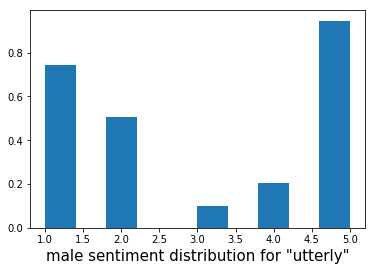

In [16]:
plt.hist(mstar,density=True)
plt.xlabel('male sentiment distribution for "{}"'.format(w),fontsize=15)
plt.show()

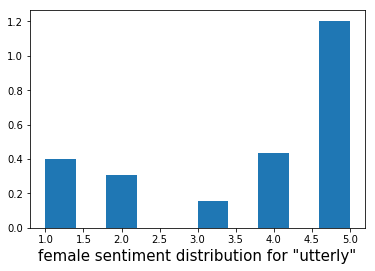

In [17]:
plt.hist(fstar,density=True)
plt.xlabel('female sentiment distribution for "{}"'.format(w),fontsize=15)
plt.show()

In [244]:
for x in Appareltrain:
    if "wife" in x:
        print(x)
        break

great food and excellent customer service . had lunch on sat . went with son and his wife . we 're chatting when bill came . glanced at bill , misread bill . payed way to much . contacted weary traveler regarding my error . they were happy to refund my overpayment . receive the check very quick . we will be back for more great food .	5

